In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance


In [2]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

from sklearn.metrics import make_scorer

score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [3]:
data = pd.read_csv('CP_Data.csv')
data = data.dropna()
features = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = features.columns

In [3]:
pearsoncorr = features.corr(method='pearson')
pearsoncorr

,Molecular Weight,Heavy Atom Molecular Weight,Max Absolute Partial Charge,Max Partial Charge,Min Abs Partial Charge,Min Partial Charge,Radical Electrons,Valence Electrons,NHOH Count,NO Count,...,Rotatable Bonds,Saturated Carbocycles,Saturated Heterocycles,H Count,C Count,N Count,F Count,Halogen Count,Double Bonds,Triple Bonds
Molecular Weight,1.000000,0.999390,-0.021021,0.047365,0.043967,0.026984,NaN,0.993779,-0.014173,0.341477,...,0.887930,NaN,-0.004454,0.935103,0.981031,0.364936,0.136923,0.138433,0.104431,-0.020494
Heavy Atom Molecular Weight,0.999390,1.000000,-0.016479,0.047755,0.044331,0.022892,NaN,0.990078,-0.009129,0.338618,...,0.873303,NaN,-0.004100,0.922161,0.977648,0.359490,0.147325,0.148916,0.097406,-0.021808
Max Absolute Partial Charge,-0.021021,-0.016479,1.000000,0.351033,0.353936,-0.998118,NaN,-0.004249,0.033238,0.576411,...,-0.041454,NaN,-0.017021,-0.065611,-0.027980,-0.159587,0.024449,0.017598,0.065057,0.042115
Max Partial Charge,0.047365,0.047755,0.351033,1.000000,0.994800,-0.338800,NaN,0.050037,-0.038278,0.334644,...,0.055059,NaN,0.052824,0.040091,0.000685,-0.265963,0.074333,0.069431,0.620787,-0.013173
Min Abs Partial Charge,0.043967,0.044331,0.353936,0.994800,1.000000,-0.357108,NaN,0.047928,-0.037732,0.333052,...,0.050335,NaN,0.054192,0.037161,-0.000646,-0.276295,0.068058,0.063178,0.626139,-0.010556
Min Partial Charge,0.026984,0.022892,-0.998118,-0.338800,-0.357108,1.000000,NaN,0.006728,-0.033879,-0.561893,...,0.043733,NaN,0.015641,0.066587,0.028842,0.163645,-0.025005,-0.018371,-0.062792,-0.044966
Radical Electrons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Valence Electrons,0.993779,0.990078,-0.004249,0.050037,0.047928,0.006728,NaN,1.000000,-0.016975,0.378797,...,0.913394,NaN,-0.001157,0.960705,0.990718,0.387552,0.119272,0.120124,0.130263,-0.012004
NHOH Count,-0.014173,-0.009129,0.033238,-0.038278,-0.037732,-0.033879,NaN,-0.016975,1.000000,0.105989,...,-0.058257,NaN,-0.003522,-0.064369,-0.017930,0.189488,0.184295,0.183935,0.032549,-0.011859
NO Count,0.341477,0.338618,0.576411,0.334644,0.333052,-0.561893,NaN,0.378797,0.105989,1.000000,...,0.366735,NaN,0.031476,0.346234,0.333433,0.450561,-0.060987,-0.065812,0.301479,0.004523


<AxesSubplot:>

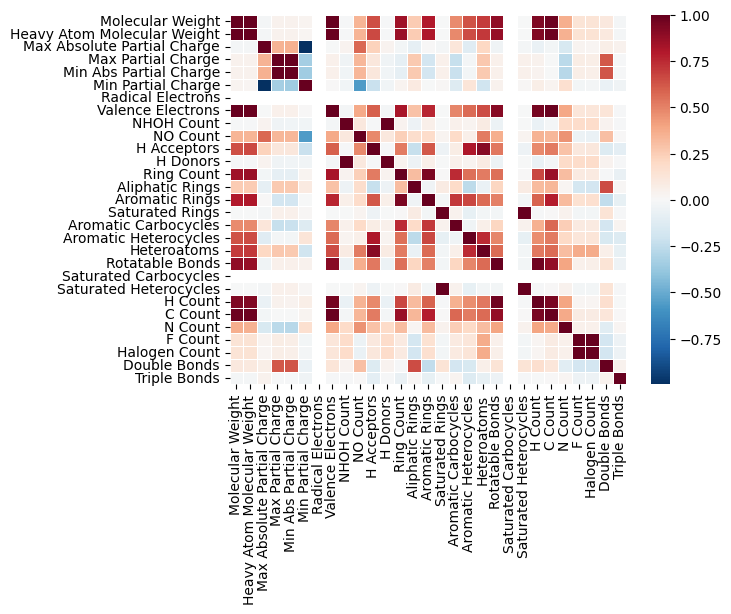

In [4]:
sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=False,
            linewidth=0.5)

In [4]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1298.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        10:54:09   Log-Likelihood:                         -678.88
No. Observations:                 780   AIC:                                      1400.
Df Residuals:                     759   BIC:                                      1498.
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0460      0.054      0.852      0.395      -0.060       0.152
Heavy Atom Molecular Weight    -0.0087      0.014     -0.600      0.549      -0.037       0.020
Max Absolute Partial Charge     1.0207      3.899      0.262      0.794      -6.633       8.674
Max Partial Charge              0.6877      3.873      0.178      0.859      -6.915       8.290
Min Abs Partial Charge          2.7285      3.918      0.696      0.486      -4.963      10.420
Min Partial Charge             -3.0615      3.882     -0.789      0.431     -10.683       4.560
Radical Electrons           -1.579e-14   7.42e-14     -0.213      0.832   -1.61e-13     1.3e-13
Valence Electrons              -0.0330      0.115     -0.287      0.774      -0.259       0.193
NHOH Count                      0.0440      0.112      0.392      0.695      -0.177       0.265
NO Count                        0.3221      0.815      0.395      0.693      -1.278       1.922
H Acceptors                     0.0763      0.064      1.199      0.231      -0.049       0.201
H Donors                        0.0440      0.112      0.392      0.695      -0.177       0.265
Ring Count                      0.0445      0.031      1.418      0.157      -0.017       0.106
Aliphatic Rings                 0.0714      0.026      2.744      0.006       0.020       0.123
Aromatic Rings                 -0.0269      0.020     -1.363      0.173      -0.066       0.012
Saturated Rings                -0.0976      0.176     -0.554      0.580      -0.443       0.248
Aromatic Carbocycles           -0.0295      0.020     -1.506      0.132      -0.068       0.009
Aromatic Heterocycles           0.0026      0.018      0.139      0.889      -0.034       0.039
Heteroatoms                    -0.9681      1.013     -0.956      0.339      -2.956       1.020
Rotatable Bonds                -0.1004      0.012     -8.253      0.000      -0.124      -0.077
Saturated Carbocycles        3.112e-15   1.32e-14      0.236      0.813   -2.27e-14     2.9e-14
Saturated Heterocycles         -0.0976      0.176     -0.554      0.580      -0.443       0.248
H Count                         0.0543      0.060      0.900      0.368      -0.064       0.173
C Count                        -0.3462      0.256     -1.351      0.177      -0.849       0.157
N Count                         0.3627      0.048      7.587      0.000       0.269       0.457
F Count                        -0.1698      0.899     -0.189      0.850      -1.935       1.595
Halogen Count                   0.7442      0.364      2.044      0.041       0.029       1.459
Double Bonds                    0.0033      0.038      0.087      0.930      -0.070       0.077
Triple B

In [6]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1364.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:35:56   Log-Likelihood:                         -678.88
No. Observations:                 780   AIC:                                      1398.
Df Residuals:                     760   BIC:                                      1491.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0451      0.053      0.852      0.395      -0.059       0.149
Heavy Atom Molecular Weight    -0.0079      0.012     -0.668      0.504      -0.031       0.015
Max Absolute Partial Charge     0.9962      3.886      0.256      0.798      -6.633       8.625
Max Partial Charge              0.6738      3.867      0.174      0.862      -6.917       8.265
Min Abs Partial Charge          2.7593      3.899      0.708      0.479      -4.895      10.414
Min Partial Charge             -3.0818      3.873     -0.796      0.426     -10.685       4.521
Radical Electrons            3.427e-14   1.25e-13      0.275      0.784   -2.11e-13    2.79e-13
Valence Electrons              -0.0306      0.112     -0.274      0.784      -0.250       0.189
NHOH Count                      0.0442      0.112      0.393      0.694      -0.176       0.265
NO Count                        0.3192      0.814      0.392      0.695      -1.278       1.917
H Acceptors                     0.0727      0.048      1.503      0.133      -0.022       0.168
H Donors                        0.0442      0.112      0.393      0.694      -0.176       0.265
Ring Count                      0.0441      0.031      1.421      0.156      -0.017       0.105
Aliphatic Rings                 0.0717      0.026      2.768      0.006       0.021       0.122
Aromatic Rings                 -0.0275      0.018     -1.493      0.136      -0.064       0.009
Saturated Rings                -0.0961      0.175     -0.548      0.584      -0.440       0.248
Aromatic Carbocycles           -0.0300      0.018     -1.631      0.103      -0.066       0.006
Aromatic Heterocycles           0.0025      0.018      0.137      0.891      -0.034       0.039
Heteroatoms                    -0.9723      1.011     -0.962      0.336      -2.957       1.012
Rotatable Bonds                -0.1005      0.012     -8.312      0.000      -0.124      -0.077
Saturated Carbocycles                0          0        nan        nan           0           0
Saturated Heterocycles         -0.0961      0.175     -0.548      0.584      -0.440       0.248
H Count                         0.0526      0.057      0.918      0.359      -0.060       0.165
C Count                        -0.3530      0.244     -1.446      0.149      -0.832       0.126
N Count                         0.3643      0.044      8.257      0.000       0.278       0.451
F Count                        -0.1729      0.898     -0.193      0.847      -1.936       1.590
Halogen Count                   0.7381      0.357      2.066      0.039       0.037       1.439
Triple Bonds                   -0.0482      0.056     -0.865      0.387      -0.158       0.061
========

In [7]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1364.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:36:50   Log-Likelihood:                         -678.88
No. Observations:                 780   AIC:                                      1398.
Df Residuals:                     760   BIC:                                      1491.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0451      0.053      0.852      0.395      -0.059       0.149
Heavy Atom Molecular Weight    -0.0079      0.012     -0.668      0.504      -0.031       0.015
Max Absolute Partial Charge     1.6700      7.748      0.216      0.829     -13.540      16.880
Min Abs Partial Charge          3.4331      0.412      8.335      0.000       2.625       4.242
Min Partial Charge             -2.4080      7.737     -0.311      0.756     -17.597      12.781
Radical Electrons            -7.46e-15   1.75e-13     -0.043      0.966   -3.51e-13    3.36e-13
Valence Electrons              -0.0306      0.112     -0.274      0.784      -0.250       0.189
NHOH Count                      0.0442      0.112      0.393      0.694      -0.176       0.265
NO Count                        0.3192      0.814      0.392      0.695      -1.278       1.917
H Acceptors                     0.0727      0.048      1.503      0.133      -0.022       0.168
H Donors                        0.0442      0.112      0.393      0.694      -0.176       0.265
Ring Count                      0.0441      0.031      1.421      0.156      -0.017       0.105
Aliphatic Rings                 0.0717      0.026      2.768      0.006       0.021       0.122
Aromatic Rings                 -0.0275      0.018     -1.493      0.136      -0.064       0.009
Saturated Rings                -0.0961      0.175     -0.548      0.584      -0.440       0.248
Aromatic Carbocycles           -0.0300      0.018     -1.631      0.103      -0.066       0.006
Aromatic Heterocycles           0.0025      0.018      0.137      0.891      -0.034       0.039
Heteroatoms                    -0.9723      1.011     -0.962      0.336      -2.957       1.012
Rotatable Bonds                -0.1005      0.012     -8.312      0.000      -0.124      -0.077
Saturated Carbocycles        4.359e-16   2.62e-15      0.166      0.868   -4.72e-15    5.59e-15
Saturated Heterocycles         -0.0961      0.175     -0.548      0.584      -0.440       0.248
H Count                         0.0526      0.057      0.918      0.359      -0.060       0.165
C Count                        -0.3530      0.244     -1.446      0.149      -0.832       0.126
N Count                         0.3643      0.044      8.257      0.000       0.278       0.451
F Count                        -0.1729      0.898     -0.193      0.847      -1.936       1.590
Halogen Count                   0.7381      0.357      2.066      0.039       0.037       1.439
Triple Bonds                   -0.0482      0.056     -0.865      0.387      -0.158       0.061
==============================================================================
Omnibus:                 

In [8]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'Min Partial Charge', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1364.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:37:15   Log-Likelihood:                         -678.88
No. Observations:                 780   AIC:                                      1398.
Df Residuals:                     760   BIC:                                      1491.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0451      0.053      0.852      0.395      -0.059       0.149
Heavy Atom Molecular Weight    -0.0079      0.012     -0.668      0.504      -0.031       0.015
Max Absolute Partial Charge     1.6700      7.748      0.216      0.829     -13.540      16.880
Min Abs Partial Charge          3.4331      0.412      8.335      0.000       2.625       4.242
Min Partial Charge             -2.4080      7.737     -0.311      0.756     -17.597      12.781
Valence Electrons              -0.0306      0.112     -0.274      0.784      -0.250       0.189
NHOH Count                      0.0442      0.112      0.393      0.694      -0.176       0.265
NO Count                        0.3192      0.814      0.392      0.695      -1.278       1.917
H Acceptors                     0.0727      0.048      1.503      0.133      -0.022       0.168
H Donors                        0.0442      0.112      0.393      0.694      -0.176       0.265
Ring Count                      0.0441      0.031      1.421      0.156      -0.017       0.105
Aliphatic Rings                 0.0717      0.026      2.768      0.006       0.021       0.122
Aromatic Rings                 -0.0275      0.018     -1.493      0.136      -0.064       0.009
Saturated Rings                -0.0961      0.175     -0.548      0.584      -0.440       0.248
Aromatic Carbocycles           -0.0300      0.018     -1.631      0.103      -0.066       0.006
Aromatic Heterocycles           0.0025      0.018      0.137      0.891      -0.034       0.039
Heteroatoms                    -0.9723      1.011     -0.962      0.336      -2.957       1.012
Rotatable Bonds                -0.1005      0.012     -8.312      0.000      -0.124      -0.077
Saturated Carbocycles       -1.328e-16   4.26e-16     -0.312      0.755   -9.69e-16    7.04e-16
Saturated Heterocycles         -0.0961      0.175     -0.548      0.584      -0.440       0.248
H Count                         0.0526      0.057      0.918      0.359      -0.060       0.165
C Count                        -0.3530      0.244     -1.446      0.149      -0.832       0.126
N Count                         0.3643      0.044      8.257      0.000       0.278       0.451
F Count                        -0.1729      0.898     -0.193      0.847      -1.936       1.590
Halogen Count                   0.7381      0.357      2.066      0.039       0.037       1.439
Triple Bonds                   -0.0482      0.056     -0.865      0.387      -0.158       0.061
==============================================================================
Omnibus:                       27.805   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Ja

In [9]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'Min Partial Charge', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1364.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:37:52   Log-Likelihood:                         -678.88
No. Observations:                 780   AIC:                                      1398.
Df Residuals:                     760   BIC:                                      1491.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0451      0.053      0.852      0.395      -0.059       0.149
Heavy Atom Molecular Weight    -0.0079      0.012     -0.668      0.504      -0.031       0.015
Max Absolute Partial Charge     1.6700      7.748      0.216      0.829     -13.540      16.880
Min Abs Partial Charge          3.4331      0.412      8.335      0.000       2.625       4.242
Min Partial Charge             -2.4080      7.737     -0.311      0.756     -17.597      12.781
Valence Electrons              -0.0306      0.112     -0.274      0.784      -0.250       0.189
NHOH Count                      0.0442      0.112      0.393      0.694      -0.176       0.265
NO Count                        0.3192      0.814      0.392      0.695      -1.278       1.917
H Acceptors                     0.0727      0.048      1.503      0.133      -0.022       0.168
H Donors                        0.0442      0.112      0.393      0.694      -0.176       0.265
Ring Count                      0.0450      0.033      1.349      0.178      -0.020       0.110
Aliphatic Rings                 0.0708      0.027      2.657      0.008       0.018       0.123
Aromatic Rings                 -0.0258      0.027     -0.967      0.334      -0.078       0.027
Saturated Rings                -0.0961      0.175     -0.548      0.584      -0.440       0.248
Aromatic Carbocycles           -0.0325      0.032     -1.023      0.307      -0.095       0.030
Heteroatoms                    -0.9723      1.011     -0.962      0.336      -2.957       1.012
Rotatable Bonds                -0.1005      0.012     -8.312      0.000      -0.124      -0.077
Saturated Carbocycles        4.782e-16   1.34e-14      0.036      0.972   -2.59e-14    2.69e-14
Saturated Heterocycles         -0.0961      0.175     -0.548      0.584      -0.440       0.248
H Count                         0.0526      0.057      0.918      0.359      -0.060       0.165
C Count                        -0.3530      0.244     -1.446      0.149      -0.832       0.126
N Count                         0.3643      0.044      8.257      0.000       0.278       0.451
F Count                        -0.1729      0.898     -0.193      0.847      -1.936       1.590
Halogen Count                   0.7381      0.357      2.066      0.039       0.037       1.439
Triple Bonds                   -0.0482      0.056     -0.865      0.387      -0.158       0.061
==============================================================================
Omnibus:                       27.805   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.748
Skew:                           0.344   Prob(JB):          

In [10]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'Min Partial Charge', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1364.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:38:24   Log-Likelihood:                         -678.88
No. Observations:                 780   AIC:                                      1398.
Df Residuals:                     760   BIC:                                      1491.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0451      0.053      0.852      0.395      -0.059       0.149
Heavy Atom Molecular Weight    -0.0079      0.012     -0.668      0.504      -0.031       0.015
Max Absolute Partial Charge     1.6700      7.748      0.216      0.829     -13.540      16.880
Min Abs Partial Charge          3.4331      0.412      8.335      0.000       2.625       4.242
Min Partial Charge             -2.4080      7.737     -0.311      0.756     -17.597      12.781
Valence Electrons              -0.0306      0.112     -0.274      0.784      -0.250       0.189
NHOH Count                      0.0442      0.112      0.393      0.694      -0.176       0.265
NO Count                        0.3192      0.814      0.392      0.695      -1.278       1.917
H Acceptors                     0.0727      0.048      1.503      0.133      -0.022       0.168
H Donors                        0.0442      0.112      0.393      0.694      -0.176       0.265
Ring Count                      0.0450      0.033      1.349      0.178      -0.020       0.110
Aliphatic Rings                 0.0708      0.027      2.657      0.008       0.018       0.123
Aromatic Rings                 -0.0258      0.027     -0.967      0.334      -0.078       0.027
Saturated Rings                -0.0961      0.175     -0.548      0.584      -0.440       0.248
Aromatic Carbocycles           -0.0325      0.032     -1.023      0.307      -0.095       0.030
Heteroatoms                    -0.9723      1.011     -0.962      0.336      -2.957       1.012
Rotatable Bonds                -0.1005      0.012     -8.312      0.000      -0.124      -0.077
Saturated Heterocycles         -0.0961      0.175     -0.548      0.584      -0.440       0.248
H Count                         0.0526      0.057      0.918      0.359      -0.060       0.165
C Count                        -0.3530      0.244     -1.446      0.149      -0.832       0.126
N Count                         0.3643      0.044      8.257      0.000       0.278       0.451
F Count                        -0.1729      0.898     -0.193      0.847      -1.936       1.590
Halogen Count                   0.7381      0.357      2.066      0.039       0.037       1.439
Triple Bonds                   -0.0482      0.056     -0.865      0.387      -0.158       0.061
==============================================================================
Omnibus:                       27.805   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.748
Skew:                           0.344   Prob(JB):                     6.35e-09
Kurtosis:                       3.829   Cond. No.                     4.96e+

In [11]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'Min Partial Charge', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'Halogen Count', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1438.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:38:54   Log-Likelihood:                         -678.90
No. Observations:                 780   AIC:                                      1396.
Df Residuals:                     761   BIC:                                      1484.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0543      0.023      2.358      0.019       0.009       0.100
Heavy Atom Molecular Weight    -0.0081      0.012     -0.685      0.493      -0.031       0.015
Max Absolute Partial Charge     2.9235      4.202      0.696      0.487      -5.326      11.173
Min Abs Partial Charge          3.4358      0.411      8.352      0.000       2.628       4.243
Min Partial Charge             -1.1544      4.183     -0.276      0.783      -9.365       7.056
Valence Electrons              -0.0493      0.056     -0.885      0.376      -0.159       0.060
NHOH Count                      0.0436      0.112      0.389      0.698      -0.177       0.264
NO Count                        0.4641      0.310      1.497      0.135      -0.145       1.073
H Acceptors                     0.0723      0.048      1.497      0.135      -0.023       0.167
H Donors                        0.0436      0.112      0.389      0.698      -0.177       0.264
Ring Count                      0.0446      0.033      1.340      0.181      -0.021       0.110
Aliphatic Rings                 0.0703      0.026      2.653      0.008       0.018       0.122
Aromatic Rings                 -0.0257      0.027     -0.963      0.336      -0.078       0.027
Saturated Rings                -0.0960      0.175     -0.548      0.584      -0.440       0.248
Aromatic Carbocycles           -0.0325      0.032     -1.022      0.307      -0.095       0.030
Heteroatoms                    -1.1492      0.423     -2.715      0.007      -1.980      -0.318
Rotatable Bonds                -0.1004      0.012     -8.317      0.000      -0.124      -0.077
Saturated Heterocycles         -0.0960      0.175     -0.548      0.584      -0.440       0.248
H Count                         0.0619      0.031      2.000      0.046       0.001       0.123
C Count                        -0.3865      0.171     -2.255      0.024      -0.723      -0.050
N Count                         0.3635      0.044      8.282      0.000       0.277       0.450
Halogen Count                   0.7016      0.303      2.319      0.021       0.108       1.295
Triple Bonds                   -0.0485      0.056     -0.871      0.384      -0.158       0.061
==============================================================================
Omnibus:                       27.752   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.674
Skew:                           0.344   Prob(JB):                     6.60e-09
Kurtosis:                       3.828   Cond. No.                     5.43e+19
==============================================================================

Notes:
[1] R²

In [12]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'Halogen Count', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1519.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:39:32   Log-Likelihood:                         -678.94
No. Observations:                 780   AIC:                                      1394.
Df Residuals:                     762   BIC:                                      1478.
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0569      0.021      2.718      0.007       0.016       0.098
Heavy Atom Molecular Weight    -0.0074      0.012     -0.641      0.522      -0.030       0.015
Max Absolute Partial Charge     4.0816      0.242     16.894      0.000       3.607       4.556
Min Abs Partial Charge          3.4202      0.407      8.398      0.000       2.621       4.220
Valence Electrons              -0.0536      0.053     -1.003      0.316      -0.158       0.051
NHOH Count                      0.0441      0.112      0.394      0.694      -0.176       0.264
NO Count                        0.5175      0.242      2.138      0.033       0.042       0.993
H Acceptors                     0.0709      0.048      1.477      0.140      -0.023       0.165
H Donors                        0.0441      0.112      0.394      0.694      -0.176       0.264
Ring Count                      0.0448      0.033      1.350      0.178      -0.020       0.110
Aliphatic Rings                 0.0704      0.026      2.659      0.008       0.018       0.122
Aromatic Rings                 -0.0255      0.027     -0.957      0.339      -0.078       0.027
Saturated Rings                -0.0961      0.175     -0.549      0.583      -0.440       0.248
Aromatic Carbocycles           -0.0321      0.032     -1.011      0.312      -0.094       0.030
Heteroatoms                    -1.2287      0.310     -3.967      0.000      -1.837      -0.621
Rotatable Bonds                -0.1007      0.012     -8.389      0.000      -0.124      -0.077
Saturated Heterocycles         -0.0961      0.175     -0.549      0.583      -0.440       0.248
H Count                         0.0638      0.030      2.117      0.035       0.005       0.123
C Count                        -0.4098      0.149     -2.750      0.006      -0.702      -0.117
N Count                         0.3653      0.043      8.418      0.000       0.280       0.451
Halogen Count                   0.7474      0.253      2.957      0.003       0.251       1.244
Triple Bonds                   -0.0480      0.056     -0.862      0.389      -0.157       0.061
==============================================================================
Omnibus:                       27.645   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.375
Skew:                           0.344   Prob(JB):                     7.66e-09
Kurtosis:                       3.822   Cond. No.                     8.07e+19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Sta

In [13]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'Halogen Count', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1519.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:40:10   Log-Likelihood:                         -678.94
No. Observations:                 780   AIC:                                      1394.
Df Residuals:                     762   BIC:                                      1478.
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0569      0.021      2.718      0.007       0.016       0.098
Heavy Atom Molecular Weight    -0.0074      0.012     -0.641      0.522      -0.030       0.015
Max Absolute Partial Charge     4.0816      0.242     16.894      0.000       3.607       4.556
Min Abs Partial Charge          3.4202      0.407      8.398      0.000       2.621       4.220
Valence Electrons              -0.0536      0.053     -1.003      0.316      -0.158       0.051
NO Count                        0.5175      0.242      2.138      0.033       0.042       0.993
H Acceptors                     0.0709      0.048      1.477      0.140      -0.023       0.165
H Donors                        0.0883      0.224      0.394      0.694      -0.352       0.528
Ring Count                      0.0448      0.033      1.350      0.178      -0.020       0.110
Aliphatic Rings                 0.0704      0.026      2.659      0.008       0.018       0.122
Aromatic Rings                 -0.0255      0.027     -0.957      0.339      -0.078       0.027
Saturated Rings                -0.0961      0.175     -0.549      0.583      -0.440       0.248
Aromatic Carbocycles           -0.0321      0.032     -1.011      0.312      -0.094       0.030
Heteroatoms                    -1.2287      0.310     -3.967      0.000      -1.837      -0.621
Rotatable Bonds                -0.1007      0.012     -8.389      0.000      -0.124      -0.077
Saturated Heterocycles         -0.0961      0.175     -0.549      0.583      -0.440       0.248
H Count                         0.0638      0.030      2.117      0.035       0.005       0.123
C Count                        -0.4098      0.149     -2.750      0.006      -0.702      -0.117
N Count                         0.3653      0.043      8.418      0.000       0.280       0.451
Halogen Count                   0.7474      0.253      2.957      0.003       0.251       1.244
Triple Bonds                   -0.0480      0.056     -0.862      0.389      -0.157       0.061
==============================================================================
Omnibus:                       27.645   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.375
Skew:                           0.344   Prob(JB):                     7.66e-09
Kurtosis:                       3.822   Cond. No.                     4.97e+19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The sma

In [14]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'Halogen Count', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1611.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:40:35   Log-Likelihood:                         -679.02
No. Observations:                 780   AIC:                                      1392.
Df Residuals:                     763   BIC:                                      1471.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0567      0.021      2.709      0.007       0.016       0.098
Heavy Atom Molecular Weight    -0.0070      0.012     -0.612      0.541      -0.030       0.016
Max Absolute Partial Charge     4.0902      0.240     17.008      0.000       3.618       4.562
Min Abs Partial Charge          3.4101      0.406      8.394      0.000       2.613       4.208
Valence Electrons              -0.0529      0.053     -0.992      0.321      -0.158       0.052
NO Count                        0.5198      0.242      2.149      0.032       0.045       0.995
H Acceptors                     0.0667      0.047      1.426      0.154      -0.025       0.158
Ring Count                      0.0451      0.033      1.359      0.174      -0.020       0.110
Aliphatic Rings                 0.0693      0.026      2.634      0.009       0.018       0.121
Aromatic Rings                 -0.0242      0.026     -0.916      0.360      -0.076       0.028
Saturated Rings                -0.0970      0.175     -0.555      0.579      -0.441       0.246
Aromatic Carbocycles           -0.0331      0.032     -1.048      0.295      -0.095       0.029
Heteroatoms                    -1.2328      0.309     -3.984      0.000      -1.840      -0.625
Rotatable Bonds                -0.1005      0.012     -8.385      0.000      -0.124      -0.077
Saturated Heterocycles         -0.0970      0.175     -0.555      0.579      -0.441       0.246
H Count                         0.0632      0.030      2.101      0.036       0.004       0.122
C Count                        -0.4136      0.149     -2.783      0.006      -0.705      -0.122
N Count                         0.3673      0.043      8.526      0.000       0.283       0.452
Halogen Count                   0.7471      0.253      2.957      0.003       0.251       1.243
Triple Bonds                   -0.0478      0.056     -0.860      0.390      -0.157       0.061
==============================================================================
Omnibus:                       27.838   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.704
Skew:                           0.346   Prob(JB):                     6.50e-09
Kurtosis:                       3.826   Cond. No.                     1.64e+19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 8.13e-30. This might indicate that there are
strong multicollinearity proble

In [15]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'H Count',
         'C Count', 'N Count', 'Halogen Count', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1611.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:41:18   Log-Likelihood:                         -679.02
No. Observations:                 780   AIC:                                      1392.
Df Residuals:                     763   BIC:                                      1471.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0567      0.021      2.709      0.007       0.016       0.098
Heavy Atom Molecular Weight    -0.0070      0.012     -0.612      0.541      -0.030       0.016
Max Absolute Partial Charge     4.0902      0.240     17.008      0.000       3.618       4.562
Min Abs Partial Charge          3.4101      0.406      8.394      0.000       2.613       4.208
Valence Electrons              -0.0529      0.053     -0.992      0.321      -0.158       0.052
NO Count                        0.5198      0.242      2.149      0.032       0.045       0.995
H Acceptors                     0.0667      0.047      1.426      0.154      -0.025       0.158
Ring Count                      0.0451      0.033      1.359      0.174      -0.020       0.110
Aliphatic Rings                 0.0693      0.026      2.634      0.009       0.018       0.121
Aromatic Rings                 -0.0242      0.026     -0.916      0.360      -0.076       0.028
Saturated Rings                -0.1941      0.350     -0.555      0.579      -0.881       0.493
Aromatic Carbocycles           -0.0331      0.032     -1.048      0.295      -0.095       0.029
Heteroatoms                    -1.2328      0.309     -3.984      0.000      -1.840      -0.625
Rotatable Bonds                -0.1005      0.012     -8.385      0.000      -0.124      -0.077
H Count                         0.0632      0.030      2.101      0.036       0.004       0.122
C Count                        -0.4136      0.149     -2.783      0.006      -0.705      -0.122
N Count                         0.3673      0.043      8.526      0.000       0.283       0.452
Halogen Count                   0.7471      0.253      2.957      0.003       0.251       1.243
Triple Bonds                   -0.0478      0.056     -0.860      0.390      -0.157       0.061
==============================================================================
Omnibus:                       27.838   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.704
Skew:                           0.346   Prob(JB):                     6.50e-09
Kurtosis:                       3.826   Cond. No.                     5.46e+18
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 7.36e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [16]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'H Count',
         'C Count', 'N Count', 'Halogen Count', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1713.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:41:53   Log-Likelihood:                         -679.18
No. Observations:                 780   AIC:                                      1390.
Df Residuals:                     764   BIC:                                      1465.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0572      0.021      2.734      0.006       0.016       0.098
Heavy Atom Molecular Weight    -0.0075      0.011     -0.654      0.514      -0.030       0.015
Max Absolute Partial Charge     4.0940      0.240     17.039      0.000       3.622       4.566
Min Abs Partial Charge          3.4020      0.406      8.384      0.000       2.605       4.199
Valence Electrons              -0.0541      0.053     -1.015      0.310      -0.159       0.051
NO Count                        0.5211      0.242      2.156      0.031       0.047       0.996
H Acceptors                     0.0670      0.047      1.433      0.152      -0.025       0.159
Ring Count                      0.0483      0.033      1.477      0.140      -0.016       0.112
Aliphatic Rings                 0.0701      0.026      2.666      0.008       0.018       0.122
Aromatic Rings                 -0.0218      0.026     -0.835      0.404      -0.073       0.029
Aromatic Carbocycles           -0.0346      0.032     -1.098      0.273      -0.096       0.027
Heteroatoms                    -1.2279      0.309     -3.972      0.000      -1.835      -0.621
Rotatable Bonds                -0.0997      0.012     -8.384      0.000      -0.123      -0.076
H Count                         0.0641      0.030      2.135      0.033       0.005       0.123
C Count                        -0.4101      0.148     -2.763      0.006      -0.701      -0.119
N Count                         0.3646      0.043      8.522      0.000       0.281       0.449
Halogen Count                   0.7512      0.252      2.976      0.003       0.256       1.247
Triple Bonds                   -0.0441      0.055     -0.799      0.424      -0.152       0.064
==============================================================================
Omnibus:                       27.613   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.493
Skew:                           0.343   Prob(JB):                     7.22e-09
Kurtosis:                       3.827   Cond. No.                     5.75e+18
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 6.65e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [17]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'H Count',
         'C Count', 'N Count', 'Halogen Count', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1713.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:42:31   Log-Likelihood:                         -679.18
No. Observations:                 780   AIC:                                      1390.
Df Residuals:                     764   BIC:                                      1465.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0496      0.015      3.344      0.001       0.021       0.079
Max Absolute Partial Charge     4.0940      0.240     17.039      0.000       3.622       4.566
Min Abs Partial Charge          3.4020      0.406      8.384      0.000       2.605       4.199
Valence Electrons              -0.0541      0.053     -1.015      0.310      -0.159       0.051
NO Count                        0.5211      0.242      2.156      0.031       0.047       0.996
H Acceptors                     0.0670      0.047      1.433      0.152      -0.025       0.159
Ring Count                      0.0483      0.033      1.477      0.140      -0.016       0.112
Aliphatic Rings                 0.0701      0.026      2.666      0.008       0.018       0.122
Aromatic Rings                 -0.0218      0.026     -0.835      0.404      -0.073       0.029
Aromatic Carbocycles           -0.0346      0.032     -1.098      0.273      -0.096       0.027
Heteroatoms                    -1.2279      0.309     -3.972      0.000      -1.835      -0.621
Rotatable Bonds                -0.0997      0.012     -8.384      0.000      -0.123      -0.076
H Count                         0.0717      0.041      1.766      0.078      -0.008       0.151
C Count                        -0.4101      0.148     -2.763      0.006      -0.701      -0.119
N Count                         0.3646      0.043      8.522      0.000       0.281       0.449
Halogen Count                   0.7512      0.252      2.976      0.003       0.256       1.247
Triple Bonds                   -0.0441      0.055     -0.799      0.424      -0.152       0.064
==============================================================================
Omnibus:                       27.613   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.493
Skew:                           0.343   Prob(JB):                     7.22e-09
Kurtosis:                       3.827   Cond. No.                     1.62e+18
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 4.8e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'H Count',
         'C Count', 'N Count', 'Halogen Count']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1828.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:42:58   Log-Likelihood:                         -679.50
No. Observations:                 780   AIC:                                      1389.
Df Residuals:                     765   BIC:                                      1459.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0492      0.015      3.320      0.001       0.020       0.078
Max Absolute Partial Charge     4.0927      0.240     17.038      0.000       3.621       4.564
Min Abs Partial Charge          3.4229      0.405      8.455      0.000       2.628       4.218
Valence Electrons              -0.0502      0.053     -0.946      0.345      -0.154       0.054
NO Count                        0.5164      0.242      2.137      0.033       0.042       0.991
H Acceptors                     0.0630      0.046      1.356      0.176      -0.028       0.154
Ring Count                      0.0623      0.028      2.262      0.024       0.008       0.116
Aliphatic Rings                 0.0762      0.025      3.029      0.003       0.027       0.126
Aromatic Rings                 -0.0138      0.024     -0.574      0.566      -0.061       0.033
Aromatic Carbocycles           -0.0343      0.031     -1.090      0.276      -0.096       0.027
Heteroatoms                    -1.2382      0.309     -4.010      0.000      -1.844      -0.632
Rotatable Bonds                -0.0960      0.011     -8.740      0.000      -0.118      -0.074
H Count                         0.0691      0.040      1.708      0.088      -0.010       0.148
C Count                        -0.4264      0.147     -2.901      0.004      -0.715      -0.138
N Count                         0.3646      0.043      8.523      0.000       0.281       0.449
Halogen Count                   0.7448      0.252      2.953      0.003       0.250       1.240
==============================================================================
Omnibus:                       26.855   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.550
Skew:                           0.334   Prob(JB):                     1.16e-08
Kurtosis:                       3.823   Cond. No.                     1.69e+18
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 4.45e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [19]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'H Count',
         'C Count', 'N Count', 'Halogen Count']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1828.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:43:30   Log-Likelihood:                         -679.50
No. Observations:                 780   AIC:                                      1389.
Df Residuals:                     765   BIC:                                      1459.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0492      0.015      3.320      0.001       0.020       0.078
Max Absolute Partial Charge     4.0927      0.240     17.038      0.000       3.621       4.564
Min Abs Partial Charge          3.4229      0.405      8.455      0.000       2.628       4.218
Valence Electrons              -0.0502      0.053     -0.946      0.345      -0.154       0.054
NO Count                        0.5164      0.242      2.137      0.033       0.042       0.991
H Acceptors                     0.0630      0.046      1.356      0.176      -0.028       0.154
Ring Count                      0.0485      0.045      1.072      0.284      -0.040       0.137
Aliphatic Rings                 0.0900      0.041      2.205      0.028       0.010       0.170
Aromatic Carbocycles           -0.0343      0.031     -1.090      0.276      -0.096       0.027
Heteroatoms                    -1.2382      0.309     -4.010      0.000      -1.844      -0.632
Rotatable Bonds                -0.0960      0.011     -8.740      0.000      -0.118      -0.074
H Count                         0.0691      0.040      1.708      0.088      -0.010       0.148
C Count                        -0.4264      0.147     -2.901      0.004      -0.715      -0.138
N Count                         0.3646      0.043      8.523      0.000       0.281       0.449
Halogen Count                   0.7448      0.252      2.953      0.003       0.250       1.240
==============================================================================
Omnibus:                       26.855   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.550
Skew:                           0.334   Prob(JB):                     1.16e-08
Kurtosis:                       3.823   Cond. No.                     2.76e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'H Count',
         'C Count', 'N Count', 'Halogen Count']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1959.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:43:53   Log-Likelihood:                         -679.96
No. Observations:                 780   AIC:                                      1388.
Df Residuals:                     766   BIC:                                      1453.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0388      0.010      3.914      0.000       0.019       0.058
Max Absolute Partial Charge     4.1179      0.239     17.251      0.000       3.649       4.587
Min Abs Partial Charge          3.3052      0.385      8.580      0.000       2.549       4.061
NO Count                        0.3424      0.157      2.187      0.029       0.035       0.650
H Acceptors                     0.0472      0.043      1.088      0.277      -0.038       0.132
Ring Count                      0.0490      0.045      1.082      0.280      -0.040       0.138
Aliphatic Rings                 0.0895      0.041      2.192      0.029       0.009       0.170
Aromatic Carbocycles           -0.0284      0.031     -0.919      0.358      -0.089       0.032
Heteroatoms                    -1.1813      0.303     -3.900      0.000      -1.776      -0.587
Rotatable Bonds                -0.0994      0.010     -9.545      0.000      -0.120      -0.079
H Count                         0.0323      0.011      2.885      0.004       0.010       0.054
C Count                        -0.5047      0.121     -4.156      0.000      -0.743      -0.266
N Count                         0.3927      0.031     12.763      0.000       0.332       0.453
Halogen Count                   0.5382      0.126      4.265      0.000       0.291       0.786
==============================================================================
Omnibus:                       25.081   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.306
Skew:                           0.325   Prob(JB):                     5.86e-08
Kurtosis:                       3.776   Cond. No.                     2.34e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings',
         'Heteroatoms', 'Rotatable Bonds', 'H Count',
         'C Count', 'N Count', 'Halogen Count']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              2110.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:44:28   Log-Likelihood:                         -680.39
No. Observations:                 780   AIC:                                      1387.
Df Residuals:                     767   BIC:                                      1447.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0406      0.010      4.184      0.000       0.022       0.060
Max Absolute Partial Charge     4.1094      0.239     17.230      0.000       3.641       4.578
Min Abs Partial Charge          3.3479      0.382      8.755      0.000       2.597       4.099
NO Count                        0.3578      0.156      2.299      0.022       0.052       0.663
H Acceptors                     0.0483      0.043      1.115      0.265      -0.037       0.133
Ring Count                      0.0343      0.042      0.811      0.418      -0.049       0.117
Aliphatic Rings                 0.1034      0.038      2.730      0.006       0.029       0.178
Heteroatoms                    -1.2241      0.299     -4.090      0.000      -1.812      -0.637
Rotatable Bonds                -0.0985      0.010     -9.502      0.000      -0.119      -0.078
H Count                         0.0315      0.011      2.822      0.005       0.010       0.053
C Count                        -0.5293      0.118     -4.470      0.000      -0.762      -0.297
N Count                         0.3980      0.030     13.162      0.000       0.339       0.457
Halogen Count                   0.5466      0.126      4.344      0.000       0.300       0.794
==============================================================================
Omnibus:                       26.272   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.734
Skew:                           0.338   Prob(JB):                     2.87e-08
Kurtosis:                       3.781   Cond. No.                     2.34e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Max Absolute Partial Charge',
         'Min Abs Partial Charge', 'NO Count',
         'H Acceptors', 'Aliphatic Rings',
         'Heteroatoms', 'Rotatable Bonds', 'H Count',
         'C Count', 'N Count', 'Halogen Count']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              2286.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:44:48   Log-Likelihood:                         -680.72
No. Observations:                 780   AIC:                                      1385.
Df Residuals:                     768   BIC:                                      1441.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0403      0.010      4.156      0.000       0.021       0.059
Max Absolute Partial Charge     4.0930      0.238     17.227      0.000       3.627       4.559
Min Abs Partial Charge          3.3271      0.381      8.723      0.000       2.578       4.076
NO Count                        0.3490      0.155      2.248      0.025       0.044       0.654
H Acceptors                     0.0588      0.041      1.423      0.155      -0.022       0.140
Aliphatic Rings                 0.1133      0.036      3.157      0.002       0.043       0.184
Heteroatoms                    -1.2173      0.299     -4.070      0.000      -1.804      -0.630
Rotatable Bonds                -0.1015      0.010    -10.502      0.000      -0.121      -0.083
H Count                         0.0291      0.011      2.705      0.007       0.008       0.050
C Count                        -0.5169      0.117     -4.403      0.000      -0.747      -0.286
N Count                         0.4012      0.030     13.392      0.000       0.342       0.460
Halogen Count                   0.5414      0.126      4.309      0.000       0.295       0.788
==============================================================================
Omnibus:                       25.992   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.810
Skew:                           0.341   Prob(JB):                     4.55e-08
Kurtosis:                       3.758   Cond. No.                     2.34e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [5]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Max Absolute Partial Charge', 'Min Abs Partial Charge', 'NO Count',
         'Aliphatic Rings', 'Heteroatoms', 'Rotatable Bonds', 'H Count', 'C Count', 'N Count', 'Halogen Count']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              2491.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        10:54:36   Log-Likelihood:                         -681.75
No. Observations:                 780   AIC:                                      1385.
Df Residuals:                     769   BIC:                                      1437.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0447      0.009      4.852      0.000       0.027       0.063
Max Absolute Partial Charge     4.2083      0.224     18.827      0.000       3.769       4.647
Min Abs Partial Charge          3.1957      0.370      8.629      0.000       2.469       3.923
NO Count                        0.4114      0.149      2.760      0.006       0.119       0.704
Aliphatic Rings                 0.0844      0.030      2.851      0.004       0.026       0.142
Heteroatoms                    -1.3007      0.293     -4.432      0.000      -1.877      -0.725
Rotatable Bonds                -0.0992      0.010    -10.404      0.000      -0.118      -0.081
H Count                         0.0226      0.010      2.318      0.021       0.003       0.042
C Count                        -0.5674      0.112     -5.066      0.000      -0.787      -0.348
N Count                         0.4121      0.029     14.215      0.000       0.355       0.469
Halogen Count                   0.5397      0.126      4.293      0.000       0.293       0.787
==============================================================================
Omnibus:                       24.989   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.098
Skew:                           0.347   Prob(JB):                     1.77e-07
Kurtosis:                       3.689   Cond. No.                     2.21e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Max Absolute Partial Charge', 'Min Abs Partial Charge', 'NO Count',
         'Aliphatic Rings', 'Heteroatoms', 'Rotatable Bonds', 'H Count', 'C Count', 'N Count', 'Halogen Count']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=0)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.6940150495700512
Train AUC ROC Score for GS:  0.9316269483189765
Test AUC ROC Score for GS:  0.7678259488645387


Mean Absolute Error: 0.17 degrees.
R2:  0.4352312879126059
MSE:  0.054661907800146854
RMSE:  0.23379886184527685


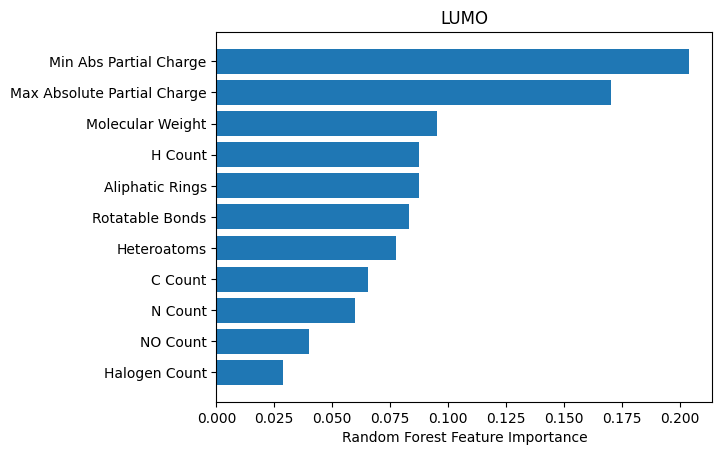

In [7]:
rfr = RandomForestRegressor(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("LUMO")

from sklearn.metrics import mean_squared_error

# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

In [10]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Aliphatic Rings0.781 +/- 0.046
Min Abs Partial Charge0.420 +/- 0.020
Max Absolute Partial Charge0.255 +/- 0.012
Heteroatoms0.220 +/- 0.012
Molecular Weight0.147 +/- 0.006
Rotatable Bonds0.142 +/- 0.007
H Count 0.130 +/- 0.005
N Count 0.126 +/- 0.006
Halogen Count0.093 +/- 0.010
C Count 0.081 +/- 0.003
NO Count0.071 +/- 0.004


In [11]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Max Absolute Partial Charge', 'Min Abs Partial Charge',
         'Aliphatic Rings', 'Heteroatoms', 'Rotatable Bonds', 'H Count', 'N Count', 'Halogen Count']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              2282.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        11:00:07   Log-Likelihood:                         -791.62
No. Observations:                 780   AIC:                                      1601.
Df Residuals:                     771   BIC:                                      1643.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight               -0.0006      0.000     -1.459      0.145      -0.001       0.000
Max Absolute Partial Charge     2.0484      0.198     10.353      0.000       1.660       2.437
Min Abs Partial Charge          3.5351      0.424      8.330      0.000       2.702       4.368
Aliphatic Rings                -0.1003      0.031     -3.206      0.001      -0.162      -0.039
Heteroatoms                     0.0716      0.021      3.411      0.001       0.030       0.113
Rotatable Bonds                -0.0995      0.011     -9.421      0.000      -0.120      -0.079
H Count                         0.0570      0.007      7.933      0.000       0.043       0.071
N Count                         0.1449      0.022      6.580      0.000       0.102       0.188
Halogen Count                   0.0351      0.031      1.126      0.260      -0.026       0.096
==============================================================================
Omnibus:                       18.179   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.516
Skew:                           0.065   Prob(JB):                     1.94e-08
Kurtosis:                       4.037   Cond. No.                     2.15e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Max Absolute Partial Charge', 'Min Abs Partial Charge',
         'Aliphatic Rings', 'Heteroatoms', 'Rotatable Bonds', 'H Count', 'N Count']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              2566.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        11:00:34   Log-Likelihood:                         -792.26
No. Observations:                 780   AIC:                                      1601.
Df Residuals:                     772   BIC:                                      1638.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight               -0.0005      0.000     -1.378      0.169      -0.001       0.000
Max Absolute Partial Charge     2.0204      0.196     10.291      0.000       1.635       2.406
Min Abs Partial Charge          3.5321      0.424      8.322      0.000       2.699       4.365
Aliphatic Rings                -0.1029      0.031     -3.298      0.001      -0.164      -0.042
Heteroatoms                     0.0757      0.021      3.660      0.000       0.035       0.116
Rotatable Bonds                -0.0989      0.011     -9.378      0.000      -0.120      -0.078
H Count                         0.0563      0.007      7.864      0.000       0.042       0.070
N Count                         0.1439      0.022      6.537      0.000       0.101       0.187
==============================================================================
Omnibus:                       17.741   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.120
Skew:                           0.068   Prob(JB):                     3.90e-08
Kurtosis:                       4.016   Cond. No.                     2.15e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Max Absolute Partial Charge', 'Min Abs Partial Charge',
         'Aliphatic Rings', 'Heteroatoms', 'Rotatable Bonds', 'H Count', 'N Count']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              2929.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        11:00:48   Log-Likelihood:                         -793.22
No. Observations:                 780   AIC:                                      1600.
Df Residuals:                     773   BIC:                                      1633.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Max Absolute Partial Charge     2.0409      0.196     10.419      0.000       1.656       2.425
Min Abs Partial Charge          3.7581      0.392      9.595      0.000       2.989       4.527
Aliphatic Rings                -0.1031      0.031     -3.302      0.001      -0.164      -0.042
Heteroatoms                     0.0521      0.012      4.473      0.000       0.029       0.075
Rotatable Bonds                -0.0894      0.008    -11.224      0.000      -0.105      -0.074
H Count                         0.0477      0.003     13.778      0.000       0.041       0.054
N Count                         0.1534      0.021      7.336      0.000       0.112       0.194
==============================================================================
Omnibus:                       18.721   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.511
Skew:                           0.081   Prob(JB):                     1.18e-08
Kurtosis:                       4.048   Cond. No.                     1.75e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=0)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.6993854475412378
Train AUC ROC Score for GS:  0.9257682561775156
Test AUC ROC Score for GS:  0.7649145095548144


Mean Absolute Error: 0.17 degrees.
R2:  0.44075341196229667
MSE:  0.054127441514736814
RMSE:  0.23265304965707373


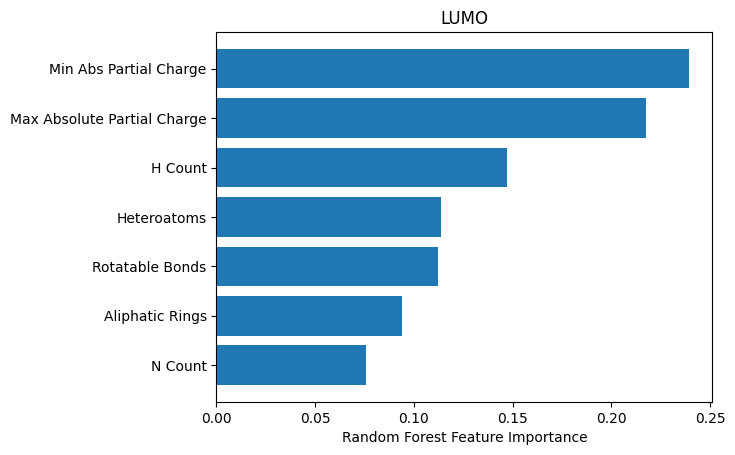

In [15]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("LUMO")

from sklearn.metrics import mean_squared_error

# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

In [16]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Aliphatic Rings0.812 +/- 0.052
Min Abs Partial Charge0.509 +/- 0.025
Max Absolute Partial Charge0.346 +/- 0.014
Heteroatoms0.333 +/- 0.018
H Count 0.228 +/- 0.009
Rotatable Bonds0.206 +/- 0.008
N Count 0.173 +/- 0.007


In [17]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              1463.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        11:12:57   Log-Likelihood:                         -958.71
No. Observations:                 780   AIC:                                      1959.
Df Residuals:                     759   BIC:                                      2057.
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.1769      0.077      2.287      0.022       0.025       0.329
Heavy Atom Molecular Weight    -0.0585      0.021     -2.833      0.005      -0.099      -0.018
Max Absolute Partial Charge     6.0468      5.581      1.083      0.279      -4.910      17.003
Max Partial Charge              6.2727      5.544      1.131      0.258      -4.611      17.156
Min Abs Partial Charge          0.0790      5.609      0.014      0.989     -10.931      11.089
Min Partial Charge              0.1469      5.558      0.026      0.979     -10.764      11.058
Radical Electrons            6.431e-14   1.06e-13      0.606      0.545   -1.44e-13    2.73e-13
Valence Electrons              -0.3061      0.165     -1.857      0.064      -0.630       0.017
NHOH Count                      0.0649      0.161      0.403      0.687      -0.251       0.381
NO Count                        1.5172      1.167      1.301      0.194      -0.773       3.807
H Acceptors                     0.4165      0.091      4.569      0.000       0.238       0.595
H Donors                        0.0649      0.161      0.403      0.687      -0.251       0.381
Ring Count                      0.0427      0.045      0.950      0.343      -0.046       0.131
Aliphatic Rings                 0.0731      0.037      1.961      0.050   -6.39e-05       0.146
Aromatic Rings                 -0.0304      0.028     -1.076      0.282      -0.086       0.025
Saturated Rings                -0.1056      0.252     -0.419      0.675      -0.601       0.390
Aromatic Carbocycles           -0.0557      0.028     -1.991      0.047      -0.111      -0.001
Aromatic Heterocycles           0.0253      0.026      0.963      0.336      -0.026       0.077
Heteroatoms                    -2.2516      1.450     -1.553      0.121      -5.098       0.595
Rotatable Bonds                -0.1648      0.017     -9.463      0.000      -0.199      -0.131
Saturated Carbocycles         -1.1e-14   1.88e-14     -0.584      0.560    -4.8e-14     2.6e-14
Saturated Heterocycles         -0.1056      0.252     -0.419      0.675      -0.601       0.390
H Count                         0.2335      0.086      2.707      0.007       0.064       0.403
C Count                        -0.2358      0.367     -0.643      0.521      -0.956       0.484
N Count                         0.3969      0.068      5.799      0.000       0.263       0.531
F Count                         0.8745      1.287      0.679      0.497      -1.652       3.401
Halogen Count                   1.3221      0.521      2.536      0.011       0.299       2.345
Double Bonds                    0.0615      0.054      1.145      0.253      -0.044       0.167
Triple B

In [29]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              1463.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:55:15   Log-Likelihood:                         -958.71
No. Observations:                 780   AIC:                                      1959.
Df Residuals:                     759   BIC:                                      2057.
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.1769      0.077      2.287      0.022       0.025       0.329
Heavy Atom Molecular Weight    -0.0585      0.021     -2.833      0.005      -0.099      -0.018
Max Absolute Partial Charge     5.9679     11.186      0.534      0.594     -15.991      27.927
Max Partial Charge              6.3516      0.652      9.747      0.000       5.072       7.631
Min Partial Charge              0.0679     11.158      0.006      0.995     -21.837      21.973
Radical Electrons           -6.434e-15   4.83e-14     -0.133      0.894   -1.01e-13    8.85e-14
Valence Electrons              -0.3061      0.165     -1.857      0.064      -0.630       0.017
NHOH Count                      0.0649      0.161      0.403      0.687      -0.251       0.381
NO Count                        1.5172      1.167      1.301      0.194      -0.773       3.807
H Acceptors                     0.4165      0.091      4.569      0.000       0.238       0.595
H Donors                        0.0649      0.161      0.403      0.687      -0.251       0.381
Ring Count                      0.0427      0.045      0.950      0.343      -0.046       0.131
Aliphatic Rings                 0.0731      0.037      1.961      0.050   -6.39e-05       0.146
Aromatic Rings                 -0.0304      0.028     -1.076      0.282      -0.086       0.025
Saturated Rings                -0.1056      0.252     -0.419      0.675      -0.601       0.390
Aromatic Carbocycles           -0.0557      0.028     -1.991      0.047      -0.111      -0.001
Aromatic Heterocycles           0.0253      0.026      0.963      0.336      -0.026       0.077
Heteroatoms                    -2.2516      1.450     -1.553      0.121      -5.098       0.595
Rotatable Bonds                -0.1648      0.017     -9.463      0.000      -0.199      -0.131
Saturated Carbocycles       -4.621e-15   1.22e-14     -0.378      0.706   -2.87e-14    1.94e-14
Saturated Heterocycles         -0.1056      0.252     -0.419      0.675      -0.601       0.390
H Count                         0.2335      0.086      2.707      0.007       0.064       0.403
C Count                        -0.2358      0.367     -0.643      0.521      -0.956       0.484
N Count                         0.3969      0.068      5.799      0.000       0.263       0.531
F Count                         0.8745      1.287      0.679      0.497      -1.652       3.401
Halogen Count                   1.3221      0.521      2.536      0.011       0.299       2.345
Double Bonds                    0.0615      0.054      1.145      0.253      -0.044       0.167
Triple Bonds                   -0.1101      0.080     -1.378      0.169      -0.267       0.047
========

In [30]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              1538.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:55:43   Log-Likelihood:                         -958.71
No. Observations:                 780   AIC:                                      1957.
Df Residuals:                     760   BIC:                                      2051.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.1765      0.042      4.234      0.000       0.095       0.258
Heavy Atom Molecular Weight    -0.0585      0.021     -2.835      0.005      -0.099      -0.018
Max Absolute Partial Charge     5.8999      0.353     16.729      0.000       5.208       6.592
Max Partial Charge              6.3521      0.646      9.827      0.000       5.083       7.621
Radical Electrons           -9.539e-16   1.21e-15     -0.787      0.431   -3.33e-15    1.42e-15
Valence Electrons              -0.3053      0.102     -2.999      0.003      -0.505      -0.105
NHOH Count                      0.0649      0.161      0.404      0.686      -0.251       0.380
NO Count                        1.5109      0.508      2.976      0.003       0.514       2.508
H Acceptors                     0.4165      0.091      4.575      0.000       0.238       0.595
H Donors                        0.0649      0.161      0.404      0.686      -0.251       0.380
Ring Count                      0.0427      0.045      0.951      0.342      -0.045       0.131
Aliphatic Rings                 0.0731      0.037      1.971      0.049       0.000       0.146
Aromatic Rings                 -0.0304      0.028     -1.079      0.281      -0.086       0.025
Saturated Rings                -0.1056      0.252     -0.419      0.675      -0.600       0.389
Aromatic Carbocycles           -0.0557      0.028     -1.997      0.046      -0.111      -0.001
Aromatic Heterocycles           0.0253      0.026      0.963      0.336      -0.026       0.077
Heteroatoms                    -2.2436      0.608     -3.690      0.000      -3.437      -1.050
Rotatable Bonds                -0.1648      0.017     -9.473      0.000      -0.199      -0.131
Saturated Carbocycles        -6.48e-16   1.36e-16     -4.766      0.000   -9.15e-16   -3.81e-16
Saturated Heterocycles         -0.1056      0.252     -0.419      0.675      -0.600       0.389
H Count                         0.2331      0.057      4.062      0.000       0.120       0.346
C Count                        -0.2342      0.251     -0.935      0.350      -0.726       0.258
N Count                         0.3969      0.068      5.804      0.000       0.263       0.531
F Count                         0.8680      0.706      1.230      0.219      -0.517       2.253
Halogen Count                   1.3226      0.512      2.581      0.010       0.317       2.329
Double Bonds                    0.0615      0.054      1.148      0.251      -0.044       0.167
Triple Bonds                   -0.1101      0.080     -1.379      0.168      -0.267       0.047
==============================================================================
Omnibus:                 

In [31]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Radical Electrons', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              1538.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:56:21   Log-Likelihood:                         -958.71
No. Observations:                 780   AIC:                                      1957.
Df Residuals:                     760   BIC:                                      2051.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.1765      0.042      4.234      0.000       0.095       0.258
Heavy Atom Molecular Weight    -0.0585      0.021     -2.835      0.005      -0.099      -0.018
Max Absolute Partial Charge     5.8999      0.353     16.729      0.000       5.208       6.592
Max Partial Charge              6.3521      0.646      9.827      0.000       5.083       7.621
Radical Electrons           -1.612e-14   1.41e-15    -11.426      0.000   -1.89e-14   -1.34e-14
Valence Electrons              -0.3053      0.102     -2.999      0.003      -0.505      -0.105
NO Count                        1.5109      0.508      2.976      0.003       0.514       2.508
H Acceptors                     0.4165      0.091      4.575      0.000       0.238       0.595
H Donors                        0.1298      0.321      0.404      0.686      -0.501       0.761
Ring Count                      0.0427      0.045      0.951      0.342      -0.045       0.131
Aliphatic Rings                 0.0731      0.037      1.971      0.049       0.000       0.146
Aromatic Rings                 -0.0304      0.028     -1.079      0.281      -0.086       0.025
Saturated Rings                -0.1056      0.252     -0.419      0.675      -0.600       0.389
Aromatic Carbocycles           -0.0557      0.028     -1.997      0.046      -0.111      -0.001
Aromatic Heterocycles           0.0253      0.026      0.963      0.336      -0.026       0.077
Heteroatoms                    -2.2436      0.608     -3.690      0.000      -3.437      -1.050
Rotatable Bonds                -0.1648      0.017     -9.473      0.000      -0.199      -0.131
Saturated Carbocycles        6.435e-16   5.26e-17     12.235      0.000     5.4e-16    7.47e-16
Saturated Heterocycles         -0.1056      0.252     -0.419      0.675      -0.600       0.389
H Count                         0.2331      0.057      4.062      0.000       0.120       0.346
C Count                        -0.2342      0.251     -0.935      0.350      -0.726       0.258
N Count                         0.3969      0.068      5.804      0.000       0.263       0.531
F Count                         0.8680      0.706      1.230      0.219      -0.517       2.253
Halogen Count                   1.3226      0.512      2.581      0.010       0.317       2.329
Double Bonds                    0.0615      0.054      1.148      0.251      -0.044       0.167
Triple Bonds                   -0.1101      0.080     -1.379      0.168      -0.267       0.047
==============================================================================
Omnibus:                       32.890   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Ja

In [32]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Radical Electrons', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              1621.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:56:40   Log-Likelihood:                         -958.79
No. Observations:                 780   AIC:                                      1956.
Df Residuals:                     761   BIC:                                      2044.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.1764      0.042      4.234      0.000       0.095       0.258
Heavy Atom Molecular Weight    -0.0581      0.021     -2.820      0.005      -0.098      -0.018
Max Absolute Partial Charge     5.9126      0.351     16.842      0.000       5.223       6.602
Max Partial Charge              6.3369      0.645      9.825      0.000       5.071       7.603
Radical Electrons            1.448e-15   3.58e-16      4.047      0.000    7.46e-16    2.15e-15
Valence Electrons              -0.3051      0.102     -2.999      0.003      -0.505      -0.105
NO Count                        1.5168      0.507      2.990      0.003       0.521       2.513
H Acceptors                     0.4106      0.090      4.571      0.000       0.234       0.587
Ring Count                      0.0427      0.045      0.951      0.342      -0.045       0.131
Aliphatic Rings                 0.0720      0.037      1.947      0.052      -0.001       0.145
Aromatic Rings                 -0.0293      0.028     -1.045      0.296      -0.084       0.026
Saturated Rings                -0.1070      0.252     -0.425      0.671      -0.602       0.387
Aromatic Carbocycles           -0.0559      0.028     -2.006      0.045      -0.111      -0.001
Aromatic Heterocycles           0.0267      0.026      1.022      0.307      -0.025       0.078
Heteroatoms                    -2.2513      0.607     -3.706      0.000      -3.444      -1.059
Rotatable Bonds                -0.1644      0.017     -9.471      0.000      -0.198      -0.130
Saturated Carbocycles        1.288e-15   1.32e-16      9.760      0.000    1.03e-15    1.55e-15
Saturated Heterocycles         -0.1070      0.252     -0.425      0.671      -0.602       0.387
H Count                         0.2326      0.057      4.056      0.000       0.120       0.345
C Count                        -0.2391      0.250     -0.956      0.339      -0.730       0.252
N Count                         0.3996      0.068      5.873      0.000       0.266       0.533
F Count                         0.8746      0.705      1.240      0.215      -0.510       2.259
Halogen Count                   1.3188      0.512      2.576      0.010       0.314       2.324
Double Bonds                    0.0617      0.054      1.154      0.249      -0.043       0.167
Triple Bonds                   -0.1099      0.080     -1.378      0.169      -0.267       0.047
==============================================================================
Omnibus:                       33.144   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.057
Skew:                           0.380   Prob(JB):          

In [33]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Radical Electrons', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              1621.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:57:08   Log-Likelihood:                         -958.79
No. Observations:                 780   AIC:                                      1956.
Df Residuals:                     761   BIC:                                      2044.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.1764      0.042      4.234      0.000       0.095       0.258
Heavy Atom Molecular Weight    -0.0581      0.021     -2.820      0.005      -0.098      -0.018
Max Absolute Partial Charge     5.9126      0.351     16.842      0.000       5.223       6.602
Max Partial Charge              6.3369      0.645      9.825      0.000       5.071       7.603
Radical Electrons           -1.485e-14    1.9e-15     -7.824      0.000   -1.86e-14   -1.11e-14
Valence Electrons              -0.3051      0.102     -2.999      0.003      -0.505      -0.105
NO Count                        1.5168      0.507      2.990      0.003       0.521       2.513
H Acceptors                     0.4106      0.090      4.571      0.000       0.234       0.587
Ring Count                      0.0427      0.045      0.951      0.342      -0.045       0.131
Aliphatic Rings                 0.0720      0.037      1.947      0.052      -0.001       0.145
Aromatic Rings                 -0.0293      0.028     -1.045      0.296      -0.084       0.026
Saturated Rings                -0.2141      0.504     -0.425      0.671      -1.203       0.775
Aromatic Carbocycles           -0.0559      0.028     -2.006      0.045      -0.111      -0.001
Aromatic Heterocycles           0.0267      0.026      1.022      0.307      -0.025       0.078
Heteroatoms                    -2.2513      0.607     -3.706      0.000      -3.444      -1.059
Rotatable Bonds                -0.1644      0.017     -9.471      0.000      -0.198      -0.130
Saturated Carbocycles       -1.906e-15   3.14e-16     -6.070      0.000   -2.52e-15   -1.29e-15
H Count                         0.2326      0.057      4.056      0.000       0.120       0.345
C Count                        -0.2391      0.250     -0.956      0.339      -0.730       0.252
N Count                         0.3996      0.068      5.873      0.000       0.266       0.533
F Count                         0.8746      0.705      1.240      0.215      -0.510       2.259
Halogen Count                   1.3188      0.512      2.576      0.010       0.314       2.324
Double Bonds                    0.0617      0.054      1.154      0.249      -0.043       0.167
Triple Bonds                   -0.1099      0.080     -1.378      0.169      -0.267       0.047
==============================================================================
Omnibus:                       33.144   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.057
Skew:                           0.380   Prob(JB):                     6.05e-11
Kurtosis:                       3.934   Cond. No.                     1.40e+

In [34]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Radical Electrons', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              1713.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:57:29   Log-Likelihood:                         -958.89
No. Observations:                 780   AIC:                                      1954.
Df Residuals:                     762   BIC:                                      2038.
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.1765      0.042      4.239      0.000       0.095       0.258
Heavy Atom Molecular Weight    -0.0581      0.021     -2.824      0.005      -0.099      -0.018
Max Absolute Partial Charge     5.9141      0.351     16.856      0.000       5.225       6.603
Max Partial Charge              6.3391      0.645      9.834      0.000       5.074       7.605
Radical Electrons            3.069e-15   1.09e-15      2.807      0.005    9.22e-16    5.22e-15
Valence Electrons              -0.3052      0.102     -3.002      0.003      -0.505      -0.106
NO Count                        1.5195      0.507      2.997      0.003       0.524       2.515
H Acceptors                     0.4086      0.090      4.558      0.000       0.233       0.585
Ring Count                      0.0453      0.044      1.021      0.308      -0.042       0.133
Aliphatic Rings                 0.0734      0.037      1.996      0.046       0.001       0.146
Aromatic Rings                 -0.0281      0.028     -1.008      0.314      -0.083       0.027
Aromatic Carbocycles           -0.0563      0.028     -2.021      0.044      -0.111      -0.002
Aromatic Heterocycles           0.0282      0.026      1.093      0.275      -0.022       0.079
Heteroatoms                    -2.2525      0.607     -3.710      0.000      -3.444      -1.061
Rotatable Bonds                -0.1636      0.017     -9.488      0.000      -0.197      -0.130
Saturated Carbocycles        7.936e-16   1.16e-16      6.862      0.000    5.67e-16    1.02e-15
H Count                         0.2328      0.057      4.061      0.000       0.120       0.345
C Count                        -0.2403      0.250     -0.961      0.337      -0.731       0.250
N Count                         0.3977      0.068      5.861      0.000       0.264       0.531
F Count                         0.8765      0.705      1.244      0.214      -0.507       2.260
Halogen Count                   1.3183      0.512      2.576      0.010       0.314       2.323
Double Bonds                    0.0596      0.053      1.120      0.263      -0.045       0.164
Triple Bonds                   -0.1060      0.079     -1.338      0.181      -0.262       0.050
==============================================================================
Omnibus:                       33.094   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.199
Skew:                           0.378   Prob(JB):                     5.63e-11
Kurtosis:                       3.939   Cond. No.                     3.12e+20
==============================================================================

Notes:
[1] R²

In [35]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Radical Electrons', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'H Count',
         'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              1814.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:57:53   Log-Likelihood:                         -959.36
No. Observations:                 780   AIC:                                      1953.
Df Residuals:                     763   BIC:                                      2032.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.1881      0.040      4.719      0.000       0.110       0.266
Heavy Atom Molecular Weight    -0.0753      0.010     -7.392      0.000      -0.095      -0.055
Max Absolute Partial Charge     5.9132      0.351     16.854      0.000       5.225       6.602
Max Partial Charge              6.2732      0.641      9.788      0.000       5.015       7.531
Radical Electrons             -2.5e-15   6.75e-16     -3.702      0.000   -3.83e-15   -1.17e-15
Valence Electrons              -0.3479      0.091     -3.803      0.000      -0.527      -0.168
NO Count                        1.4352      0.499      2.875      0.004       0.455       2.415
H Acceptors                     0.4615      0.071      6.526      0.000       0.323       0.600
Ring Count                      0.0444      0.044      1.000      0.318      -0.043       0.132
Aliphatic Rings                 0.0720      0.037      1.958      0.051      -0.000       0.144
Aromatic Rings                 -0.0276      0.028     -0.990      0.322      -0.082       0.027
Aromatic Carbocycles           -0.0593      0.028     -2.142      0.033      -0.114      -0.005
Aromatic Heterocycles           0.0317      0.026      1.241      0.215      -0.018       0.082
Heteroatoms                    -1.8782      0.466     -4.032      0.000      -2.793      -0.964
Rotatable Bonds                -0.1604      0.017     -9.477      0.000      -0.194      -0.127
Saturated Carbocycles         7.59e-16   5.69e-17     13.327      0.000    6.47e-16    8.71e-16
H Count                         0.2613      0.049      5.330      0.000       0.165       0.358
N Count                         0.3474      0.043      8.025      0.000       0.262       0.432
F Count                         0.7773      0.697      1.115      0.265      -0.591       2.146
Halogen Count                   1.4462      0.494      2.927      0.004       0.476       2.416
Double Bonds                    0.0865      0.045      1.912      0.056      -0.002       0.175
Triple Bonds                   -0.1124      0.079     -1.423      0.155      -0.267       0.043
==============================================================================
Omnibus:                       34.470   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.379
Skew:                           0.389   Prob(JB):                     1.89e-11
Kurtosis:                       3.957   Cond. No.                     3.19e+22
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Sta

In [36]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Radical Electrons', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'H Count',
         'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              1814.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:58:19   Log-Likelihood:                         -959.36
No. Observations:                 780   AIC:                                      1953.
Df Residuals:                     763   BIC:                                      2032.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.1881      0.040      4.719      0.000       0.110       0.266
Heavy Atom Molecular Weight    -0.0753      0.010     -7.392      0.000      -0.095      -0.055
Max Absolute Partial Charge     5.9132      0.351     16.854      0.000       5.225       6.602
Max Partial Charge              6.2732      0.641      9.788      0.000       5.015       7.531
Radical Electrons           -1.162e-14   2.02e-15     -5.759      0.000   -1.56e-14   -7.66e-15
Valence Electrons              -0.3479      0.091     -3.803      0.000      -0.527      -0.168
NO Count                        1.4352      0.499      2.875      0.004       0.455       2.415
H Acceptors                     0.4615      0.071      6.526      0.000       0.323       0.600
Ring Count                      0.0306      0.054      0.572      0.568      -0.074       0.136
Aliphatic Rings                 0.0858      0.040      2.130      0.034       0.007       0.165
Aromatic Carbocycles           -0.0731      0.037     -1.950      0.052      -0.147       0.000
Aromatic Heterocycles           0.0179      0.034      0.522      0.602      -0.049       0.085
Heteroatoms                    -1.8782      0.466     -4.032      0.000      -2.793      -0.964
Rotatable Bonds                -0.1604      0.017     -9.477      0.000      -0.194      -0.127
Saturated Carbocycles        3.291e-16   1.38e-16      2.390      0.017    5.88e-17    5.99e-16
H Count                         0.2613      0.049      5.330      0.000       0.165       0.358
N Count                         0.3474      0.043      8.025      0.000       0.262       0.432
F Count                         0.7773      0.697      1.115      0.265      -0.591       2.146
Halogen Count                   1.4462      0.494      2.927      0.004       0.476       2.416
Double Bonds                    0.0865      0.045      1.912      0.056      -0.002       0.175
Triple Bonds                   -0.1124      0.079     -1.423      0.155      -0.267       0.043
==============================================================================
Omnibus:                       34.470   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.379
Skew:                           0.389   Prob(JB):                     1.89e-11
Kurtosis:                       3.957   Cond. No.                     1.07e+21
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The sma

In [37]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Radical Electrons', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'H Count',
         'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              1814.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:58:52   Log-Likelihood:                         -959.36
No. Observations:                 780   AIC:                                      1953.
Df Residuals:                     763   BIC:                                      2032.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.1881      0.040      4.719      0.000       0.110       0.266
Heavy Atom Molecular Weight    -0.0753      0.010     -7.392      0.000      -0.095      -0.055
Max Absolute Partial Charge     5.9132      0.351     16.854      0.000       5.225       6.602
Max Partial Charge              6.2732      0.641      9.788      0.000       5.015       7.531
Radical Electrons           -1.146e-14   1.08e-15    -10.622      0.000   -1.36e-14   -9.34e-15
Valence Electrons              -0.3479      0.091     -3.803      0.000      -0.527      -0.168
NO Count                        1.4352      0.499      2.875      0.004       0.455       2.415
H Acceptors                     0.4615      0.071      6.526      0.000       0.323       0.600
Ring Count                      0.0485      0.078      0.621      0.535      -0.105       0.202
Aliphatic Rings                 0.0679      0.060      1.129      0.259      -0.050       0.186
Aromatic Carbocycles           -0.0910      0.045     -2.004      0.045      -0.180      -0.002
Heteroatoms                    -1.8782      0.466     -4.032      0.000      -2.793      -0.964
Rotatable Bonds                -0.1604      0.017     -9.477      0.000      -0.194      -0.127
Saturated Carbocycles        1.471e-15   2.21e-16      6.668      0.000    1.04e-15     1.9e-15
H Count                         0.2613      0.049      5.330      0.000       0.165       0.358
N Count                         0.3474      0.043      8.025      0.000       0.262       0.432
F Count                         0.7773      0.697      1.115      0.265      -0.591       2.146
Halogen Count                   1.4462      0.494      2.927      0.004       0.476       2.416
Double Bonds                    0.0865      0.045      1.912      0.056      -0.002       0.175
Triple Bonds                   -0.1124      0.079     -1.423      0.155      -0.267       0.043
==============================================================================
Omnibus:                       34.470   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.379
Skew:                           0.389   Prob(JB):                     1.89e-11
Kurtosis:                       3.957   Cond. No.                     2.18e+20
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 4.6e-32. This might indicate that there are
strong multicollinearity problem

In [38]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Radical Electrons', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Aliphatic Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'H Count',
         'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              1928.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:59:13   Log-Likelihood:                         -959.56
No. Observations:                 780   AIC:                                      1951.
Df Residuals:                     764   BIC:                                      2026.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.1877      0.040      4.712      0.000       0.110       0.266
Heavy Atom Molecular Weight    -0.0738      0.010     -7.465      0.000      -0.093      -0.054
Max Absolute Partial Charge     5.8871      0.348     16.909      0.000       5.204       6.571
Max Partial Charge              6.2971      0.639      9.847      0.000       5.042       7.552
Radical Electrons            5.879e-15   4.97e-16     11.825      0.000     4.9e-15    6.86e-15
Valence Electrons              -0.3486      0.091     -3.812      0.000      -0.528      -0.169
NO Count                        1.4462      0.499      2.900      0.004       0.467       2.425
H Acceptors                     0.4660      0.070      6.627      0.000       0.328       0.604
Aliphatic Rings                 0.0832      0.055      1.517      0.130      -0.024       0.191
Aromatic Carbocycles           -0.0846      0.044     -1.914      0.056      -0.171       0.002
Heteroatoms                    -1.9019      0.464     -4.098      0.000      -2.813      -0.991
Rotatable Bonds                -0.1649      0.015    -10.798      0.000      -0.195      -0.135
Saturated Carbocycles        -1.23e-15   1.56e-16     -7.896      0.000   -1.54e-15   -9.24e-16
H Count                         0.2594      0.049      5.304      0.000       0.163       0.355
N Count                         0.3538      0.042      8.414      0.000       0.271       0.436
F Count                         0.7956      0.696      1.143      0.254      -0.571       2.162
Halogen Count                   1.4282      0.493      2.896      0.004       0.460       2.396
Double Bonds                    0.0794      0.044      1.815      0.070      -0.006       0.165
Triple Bonds                   -0.1381      0.067     -2.055      0.040      -0.270      -0.006
==============================================================================
Omnibus:                       33.641   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.596
Skew:                           0.385   Prob(JB):                     4.62e-11
Kurtosis:                       3.933   Cond. No.                     2.45e+20
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 3.65e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [39]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Radical Electrons', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Aliphatic Rings', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'H Count',
         'N Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              2056.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:59:37   Log-Likelihood:                         -960.22
No. Observations:                 780   AIC:                                      1950.
Df Residuals:                     765   BIC:                                      2020.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.1553      0.028      5.549      0.000       0.100       0.210
Heavy Atom Molecular Weight    -0.0664      0.007     -8.869      0.000      -0.081      -0.052
Max Absolute Partial Charge     5.9202      0.347     17.059      0.000       5.239       6.601
Max Partial Charge              6.1532      0.627      9.812      0.000       4.922       7.384
Radical Electrons           -1.171e-14   9.69e-16    -12.090      0.000   -1.36e-14   -9.81e-15
Valence Electrons              -0.2739      0.064     -4.280      0.000      -0.400      -0.148
NO Count                        1.0403      0.350      2.970      0.003       0.353       1.728
H Acceptors                     0.4524      0.069      6.526      0.000       0.316       0.588
Aliphatic Rings                 0.0876      0.055      1.601      0.110      -0.020       0.195
Aromatic Carbocycles           -0.0812      0.044     -1.840      0.066      -0.168       0.005
Heteroatoms                    -1.5267      0.328     -4.654      0.000      -2.171      -0.883
Rotatable Bonds                -0.1682      0.015    -11.213      0.000      -0.198      -0.139
Saturated Carbocycles       -2.359e-15   1.45e-16    -16.275      0.000   -2.64e-15   -2.07e-15
H Count                         0.2200      0.035      6.349      0.000       0.152       0.288
N Count                         0.3755      0.038     10.006      0.000       0.302       0.449
Halogen Count                   1.8012      0.370      4.873      0.000       1.076       2.527
Double Bonds                    0.0767      0.044      1.754      0.080      -0.009       0.162
Triple Bonds                   -0.1353      0.067     -2.014      0.044      -0.267      -0.003
==============================================================================
Omnibus:                       32.071   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.166
Skew:                           0.380   Prob(JB):                     2.57e-10
Kurtosis:                       3.884   Cond. No.                     1.06e+21
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.94e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Radical Electrons', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'H Count',
         'N Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              2198.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        11:13:34   Log-Likelihood:                         -961.53
No. Observations:                 780   AIC:                                      1951.
Df Residuals:                     766   BIC:                                      2016.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.1557      0.028      5.557      0.000       0.101       0.211
Heavy Atom Molecular Weight    -0.0660      0.007     -8.813      0.000      -0.081      -0.051
Max Absolute Partial Charge     5.8821      0.347     16.972      0.000       5.202       6.562
Max Partial Charge              6.1507      0.628      9.798      0.000       4.918       7.383
Radical Electrons           -1.123e-14   9.27e-16    -12.116      0.000    -1.3e-14   -9.41e-15
Valence Electrons              -0.2748      0.064     -4.289      0.000      -0.401      -0.149
NO Count                        1.0656      0.350      3.042      0.002       0.378       1.753
H Acceptors                     0.4101      0.064      6.392      0.000       0.284       0.536
Aromatic Carbocycles           -0.0968      0.043     -2.248      0.025      -0.181      -0.012
Heteroatoms                    -1.5219      0.328     -4.634      0.000      -2.167      -0.877
Rotatable Bonds                -0.1729      0.015    -11.732      0.000      -0.202      -0.144
Saturated Carbocycles        1.575e-15   2.05e-16      7.667      0.000    1.17e-15    1.98e-15
H Count                         0.2200      0.035      6.343      0.000       0.152       0.288
N Count                         0.3722      0.038      9.923      0.000       0.299       0.446
Halogen Count                   1.7785      0.370      4.810      0.000       1.053       2.504
Double Bonds                    0.0858      0.043      1.978      0.048       0.001       0.171
Triple Bonds                   -0.1543      0.066     -2.332      0.020      -0.284      -0.024
==============================================================================
Omnibus:                       28.055   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.660
Skew:                           0.351   Prob(JB):                     6.64e-09
Kurtosis:                       3.816   Cond. No.                     1.12e+20
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.76e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [19]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Radical Electrons', 'Valence Electrons', 'NO Count',
         'H Acceptors', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'H Count',
         'N Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=0)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
CV score for GS 0.7165073810317183
Train AUC ROC Score for GS:  0.8995679876510623
Test AUC ROC Score for GS:  0.7059260438219535


Mean Absolute Error: 0.15 degrees.
R2:  0.24747988956563394
MSE:  0.043168703208093816
RMSE:  0.20777079488728395


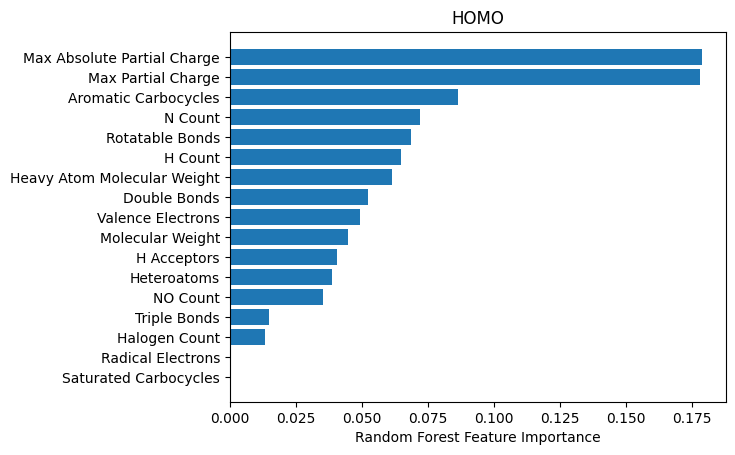

In [20]:
rfr = RandomForestRegressor(random_state=42, max_depth=None, min_samples_leaf=2, min_samples_split=5)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

from sklearn.metrics import mean_squared_error

# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

In [21]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Max Partial Charge0.386 +/- 0.017
Aromatic Carbocycles0.360 +/- 0.021
Max Absolute Partial Charge0.306 +/- 0.018
N Count 0.163 +/- 0.011
Double Bonds0.122 +/- 0.008
Rotatable Bonds0.079 +/- 0.006
H Count 0.073 +/- 0.004
Heavy Atom Molecular Weight0.073 +/- 0.004
H Acceptors0.053 +/- 0.004
Valence Electrons0.048 +/- 0.002
Molecular Weight0.044 +/- 0.002
Heteroatoms0.043 +/- 0.003
NO Count0.037 +/- 0.003
Halogen Count0.018 +/- 0.002
Triple Bonds0.014 +/- 0.002


In [22]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Valence Electrons', 'NO Count',
         'H Acceptors', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'H Count',
         'N Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              2198.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        11:16:54   Log-Likelihood:                         -961.53
No. Observations:                 780   AIC:                                      1951.
Df Residuals:                     766   BIC:                                      2016.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.1557      0.028      5.557      0.000       0.101       0.211
Heavy Atom Molecular Weight    -0.0660      0.007     -8.813      0.000      -0.081      -0.051
Max Absolute Partial Charge     5.8821      0.347     16.972      0.000       5.202       6.562
Max Partial Charge              6.1507      0.628      9.798      0.000       4.918       7.383
Valence Electrons              -0.2748      0.064     -4.289      0.000      -0.401      -0.149
NO Count                        1.0656      0.350      3.042      0.002       0.378       1.753
H Acceptors                     0.4101      0.064      6.392      0.000       0.284       0.536
Aromatic Carbocycles           -0.0968      0.043     -2.248      0.025      -0.181      -0.012
Heteroatoms                    -1.5219      0.328     -4.634      0.000      -2.167      -0.877
Rotatable Bonds                -0.1729      0.015    -11.732      0.000      -0.202      -0.144
H Count                         0.2200      0.035      6.343      0.000       0.152       0.288
N Count                         0.3722      0.038      9.923      0.000       0.299       0.446
Halogen Count                   1.7785      0.370      4.810      0.000       1.053       2.504
Double Bonds                    0.0858      0.043      1.978      0.048       0.001       0.171
Triple Bonds                   -0.1543      0.066     -2.332      0.020      -0.284      -0.024
==============================================================================
Omnibus:                       28.055   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.660
Skew:                           0.351   Prob(JB):                     6.64e-09
Kurtosis:                       3.816   Cond. No.                     1.92e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 5.97e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [23]:
param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=0)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
CV score for GS 0.7169041539319081
Train AUC ROC Score for GS:  0.9054985516059298
Test AUC ROC Score for GS:  0.7071993209188816


Mean Absolute Error: 0.15 degrees.
R2:  0.24760469915825556
MSE:  0.04316154344161489
RMSE:  0.2077535642091728


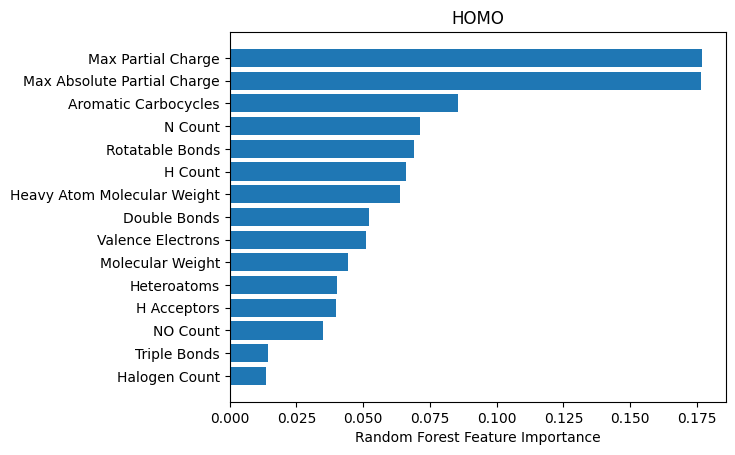

In [26]:
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=2, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

from sklearn.metrics import mean_squared_error

# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

Mean Absolute Error: 0.15 degrees.
R2:  0.24108848724398058
MSE:  0.04353534928981476
RMSE:  0.20865126237292397


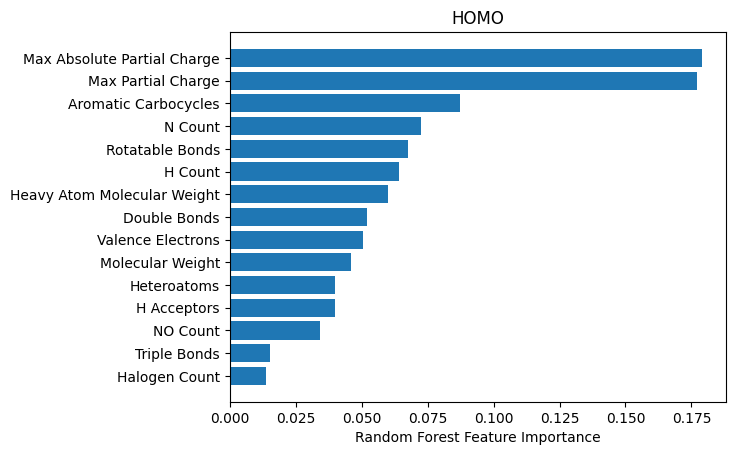

In [27]:
rfr = RandomForestRegressor(random_state=42, max_depth=None, min_samples_leaf=2, min_samples_split=5)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

from sklearn.metrics import mean_squared_error

# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

In [28]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Max Partial Charge0.386 +/- 0.017
Aromatic Carbocycles0.361 +/- 0.021
Max Absolute Partial Charge0.309 +/- 0.018
N Count 0.163 +/- 0.011
Double Bonds0.121 +/- 0.007
Rotatable Bonds0.078 +/- 0.006
H Count 0.073 +/- 0.004
Heavy Atom Molecular Weight0.070 +/- 0.004
H Acceptors0.053 +/- 0.004
Valence Electrons0.050 +/- 0.002
Molecular Weight0.046 +/- 0.002
Heteroatoms0.045 +/- 0.003
NO Count0.038 +/- 0.003
Halogen Count0.018 +/- 0.002
Triple Bonds0.015 +/- 0.002


In [29]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Valence Electrons', 'NO Count',
         'H Acceptors', 'Aromatic Carbocycles',
         'Heteroatoms', 'Rotatable Bonds', 'H Count',
         'N Count', 'Double Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.974
Method:                 Least Squares   F-statistic:                              2478.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        11:20:48   Log-Likelihood:                         -975.58
No. Observations:                 780   AIC:                                      1975.
Df Residuals:                     768   BIC:                                      2031.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0231      0.006      3.939      0.000       0.012       0.035
Heavy Atom Molecular Weight    -0.0341      0.004     -8.889      0.000      -0.042      -0.027
Max Absolute Partial Charge     5.9355      0.350     16.947      0.000       5.248       6.623
Max Partial Charge              5.7046      0.626      9.112      0.000       4.476       6.934
Valence Electrons               0.0260      0.014      1.896      0.058      -0.001       0.053
NO Count                       -0.5805      0.077     -7.505      0.000      -0.732      -0.429
H Acceptors                     0.3034      0.061      4.982      0.000       0.184       0.423
Aromatic Carbocycles           -0.0748      0.043     -1.723      0.085      -0.160       0.010
Heteroatoms                     0.0428      0.046      0.932      0.351      -0.047       0.133
Rotatable Bonds                -0.1756      0.014    -12.128      0.000      -0.204      -0.147
H Count                         0.0568      0.009      6.544      0.000       0.040       0.074
N Count                         0.4564      0.033     13.718      0.000       0.391       0.522
Double Bonds                    0.0545      0.044      1.251      0.211      -0.031       0.140
==============================================================================
Omnibus:                       16.608   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.780
Skew:                           0.171   Prob(JB):                     2.52e-06
Kurtosis:                       3.822   Cond. No.                     1.91e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 6.01e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [30]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Valence Electrons', 'NO Count',
         'H Acceptors', 'Aromatic Carbocycles',
         'Rotatable Bonds', 'H Count',
         'N Count']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.974
Method:                 Least Squares   F-statistic:                              2974.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        11:21:07   Log-Likelihood:                         -976.51
No. Observations:                 780   AIC:                                      1973.
Df Residuals:                     770   BIC:                                      2020.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0246      0.006      4.351      0.000       0.014       0.036
Heavy Atom Molecular Weight    -0.0320      0.003     -9.905      0.000      -0.038      -0.026
Max Absolute Partial Charge     5.8427      0.340     17.201      0.000       5.176       6.509
Max Partial Charge              6.1633      0.527     11.695      0.000       5.129       7.198
Valence Electrons               0.0177      0.012      1.442      0.150      -0.006       0.042
NO Count                       -0.5015      0.051     -9.857      0.000      -0.601      -0.402
H Acceptors                     0.2573      0.046      5.630      0.000       0.168       0.347
Aromatic Carbocycles           -0.1070      0.036     -2.987      0.003      -0.177      -0.037
Rotatable Bonds                -0.1712      0.014    -12.458      0.000      -0.198      -0.144
H Count                         0.0561      0.008      6.754      0.000       0.040       0.072
N Count                         0.4500      0.032     14.268      0.000       0.388       0.512
==============================================================================
Omnibus:                       17.268   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.249
Skew:                           0.158   Prob(JB):                     7.34e-07
Kurtosis:                       3.877   Cond. No.                     1.90e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 6.06e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [31]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'NO Count',
         'H Acceptors', 'Aromatic Carbocycles',
         'Rotatable Bonds', 'H Count',
         'N Count']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.974
Method:                 Least Squares   F-statistic:                              3300.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        11:21:15   Log-Likelihood:                         -977.56
No. Observations:                 780   AIC:                                      1973.
Df Residuals:                     771   BIC:                                      2015.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0319      0.003     12.687      0.000       0.027       0.037
Heavy Atom Molecular Weight    -0.0338      0.003    -11.414      0.000      -0.040      -0.028
Max Absolute Partial Charge     5.9885      0.324     18.456      0.000       5.352       6.626
Max Partial Charge              6.0726      0.524     11.598      0.000       5.045       7.100
NO Count                       -0.4424      0.030    -14.675      0.000      -0.502      -0.383
H Acceptors                     0.2077      0.030      6.901      0.000       0.149       0.267
Aromatic Carbocycles           -0.0760      0.029     -2.652      0.008      -0.132      -0.020
Rotatable Bonds                -0.1637      0.013    -12.855      0.000      -0.189      -0.139
H Count                         0.0652      0.005     12.029      0.000       0.055       0.076
N Count                         0.4490      0.032     14.232      0.000       0.387       0.511
==============================================================================
Omnibus:                       16.730   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.248
Skew:                           0.169   Prob(JB):                     2.00e-06
Kurtosis:                       3.833   Cond. No.                     1.84e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 6.06e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [32]:
param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=0)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5}
CV score for GS 0.7135645947852431
Train AUC ROC Score for GS:  0.9046799667220186
Test AUC ROC Score for GS:  0.7072789007374396


Mean Absolute Error: 0.15 degrees.
R2:  0.23313201200435596
MSE:  0.043991776584500146
RMSE:  0.20974216692048395


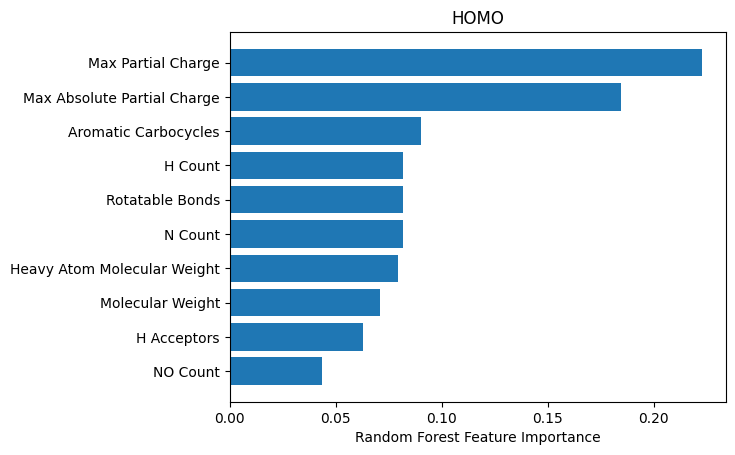

In [33]:
rfr = RandomForestRegressor(random_state=42, max_depth=15, min_samples_leaf=1, min_samples_split=5)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

from sklearn.metrics import mean_squared_error

# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

In [34]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Max Partial Charge0.490 +/- 0.020
Aromatic Carbocycles0.410 +/- 0.022
Max Absolute Partial Charge0.334 +/- 0.017
N Count 0.211 +/- 0.013
Rotatable Bonds0.107 +/- 0.007
Heavy Atom Molecular Weight0.107 +/- 0.005
H Count 0.100 +/- 0.006
H Acceptors0.089 +/- 0.006
Molecular Weight0.082 +/- 0.004
NO Count0.052 +/- 0.004


In [35]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              2884.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        11:26:34   Log-Likelihood:                         -1073.6
No. Observations:                 780   AIC:                                      2163.
Df Residuals:                     772   BIC:                                      2201.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Molecular Weight                0.0290      0.003     10.232      0.000       0.023       0.035
Heavy Atom Molecular Weight    -0.0279      0.003     -8.415      0.000      -0.034      -0.021
Max Absolute Partial Charge     4.1875      0.340     12.334      0.000       3.521       4.854
Max Partial Charge              3.3500      0.553      6.053      0.000       2.264       4.436
H Acceptors                     0.0633      0.032      1.970      0.049       0.000       0.126
Aromatic Carbocycles           -0.2156      0.031     -7.059      0.000      -0.276      -0.156
Rotatable Bonds                -0.1842      0.014    -12.871      0.000      -0.212      -0.156
H Count                         0.0565      0.006      9.272      0.000       0.045       0.068
N Count                         0.2305      0.031      7.332      0.000       0.169       0.292
==============================================================================
Omnibus:                       17.057   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.999
Skew:                           0.200   Prob(JB):                     3.73e-06
Kurtosis:                       3.780   Cond. No.                     1.83e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 6.13e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [36]:
param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=0)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5}
CV score for GS 0.7140180645907278
Train AUC ROC Score for GS:  0.905211211605863
Test AUC ROC Score for GS:  0.7082869117725078


Mean Absolute Error: 0.15 degrees.
R2:  0.24199667694619087
MSE:  0.04348325052040283
RMSE:  0.20852637847620822


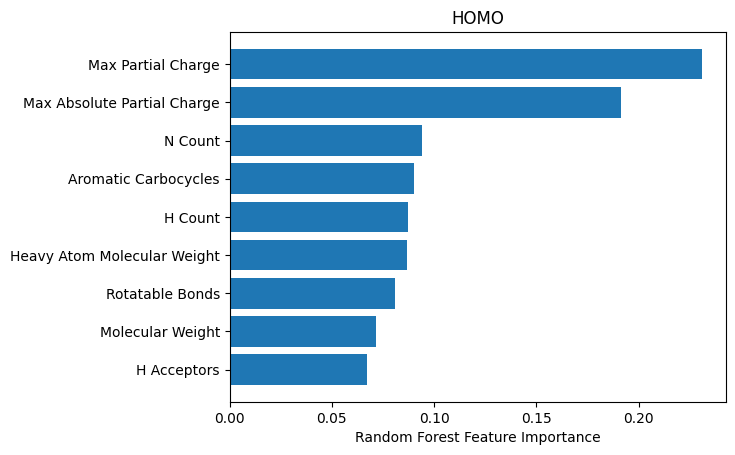

In [37]:
rfr = RandomForestRegressor(random_state=42, max_depth=15, min_samples_leaf=1, min_samples_split=5)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

from sklearn.metrics import mean_squared_error

# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

In [38]:
r = permutation_importance(rfr, X_train, y_train,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{list_numerical[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")

Max Partial Charge0.505 +/- 0.019
Aromatic Carbocycles0.407 +/- 0.023
Max Absolute Partial Charge0.337 +/- 0.017
N Count 0.227 +/- 0.013
Heavy Atom Molecular Weight0.119 +/- 0.006
H Count 0.109 +/- 0.006
Rotatable Bonds0.108 +/- 0.006
H Acceptors0.094 +/- 0.006
Molecular Weight0.077 +/- 0.003


In [39]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Heavy Atom Molecular Weight', 'Max Absolute Partial Charge', 'Max Partial Charge', 
         'Aromatic Carbocycles',
         'Rotatable Bonds', 'H Count',
         'N Count']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -HOMO(eV)   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              3284.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):                        0.00
Time:                        11:32:50   Log-Likelihood:                         -1075.6
No. Observations:                 780   AIC:                                      2165.
Df Residuals:                     773   BIC:                                      2198.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Heavy Atom Molecular Weight     0.0022      0.000      6.988      0.000       0.002       0.003
Max Absolute Partial Charge     4.5795      0.276     16.616      0.000       4.038       5.121
Max Partial Charge              3.1938      0.549      5.820      0.000       2.117       4.271
Aromatic Carbocycles           -0.2509      0.025    -10.114      0.000      -0.300      -0.202
Rotatable Bonds                -0.1740      0.013    -13.017      0.000      -0.200      -0.148
H Count                         0.0745      0.007     10.800      0.000       0.061       0.088
N Count                         0.2558      0.029      8.896      0.000       0.199       0.312
==============================================================================
Omnibus:                       15.687   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.436
Skew:                           0.174   Prob(JB):                     8.15e-06
Kurtosis:                       3.774   Cond. No.                     1.84e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=0)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5}
CV score for GS 0.7146102404962782
Train AUC ROC Score for GS:  0.9024347053261476
Test AUC ROC Score for GS:  0.703538649265213


Mean Absolute Error: 0.15 degrees.
R2:  0.23141934394210506
MSE:  0.04409002466883455
RMSE:  0.20997624786826377


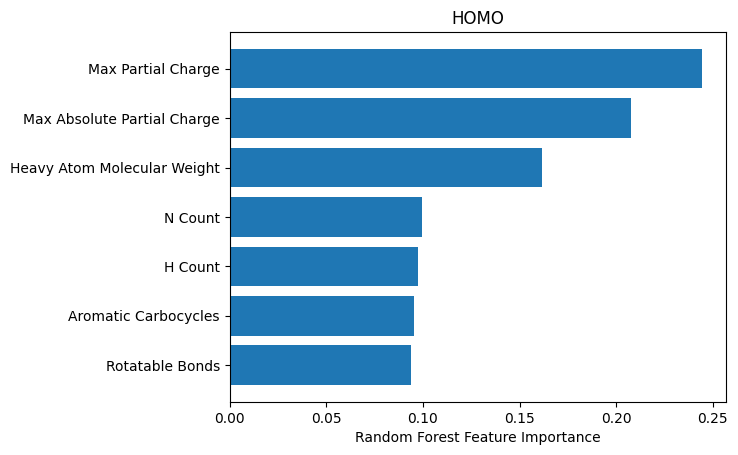

In [41]:
rfr = RandomForestRegressor(random_state=42, max_depth=15, min_samples_leaf=1, min_samples_split=5)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("HOMO")

from sklearn.metrics import mean_squared_error

# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)